# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [18]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')


In [19]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


In [20]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [123]:
# Try loading one file

#df = pd.read_parquet('/Users/tapankumarpradhan/Documents/ML/EDA/Assignment/Datasets_and_Dictionary/trip_records/2023-1.parquet')
#df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [22]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/My Drive/ML/EDA/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    print(f"Processing file {file_name}")
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file

        cur_df=pd.read_parquet(file_path)

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for dy in range(1,32):
            # Iterate through each hour of the selected date
            for hr in range(0,24):

                # Sample 5% of the hourly data randomly
                hour_df=cur_df[(cur_df.tpep_pickup_datetime.dt.day==dy) & (cur_df.tpep_pickup_datetime.dt.hour==hr)]
                sample=hour_df.sample(frac = 0.05, random_state = 42)
                # add data of this hour to the dataframe
                if len(sample) > 0:
                    sampled_data = pd.concat([sampled_data, sample])

                # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data])# we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Processing file 2023-1.parquet
Processing file 2023-5.parquet
Processing file 2023-4.parquet
Processing file 2023-3.parquet
Processing file 2023-2.parquet
Processing file 2023-8.parquet
Processing file 2023-7.parquet
Processing file 2023-6.parquet
Processing file 2023-12.parquet
Processing file 2023-11.parquet
Processing file 2023-10.parquet
Processing file 2023-9.parquet


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1896420 entries, 3703 to 119
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            float

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [26]:
# Store the df in csv/parquet
df.to_parquet('/content/drive/My Drive/ML/EDA/sampled_data.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [27]:
# Load the new data file
df=pd.read_parquet('/content/drive/My Drive/ML/EDA/sampled_data.parquet')


In [28]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3703            2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
4166            2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
3847            2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
1882            2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   
2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3703              2.85         1.0                  N           263   
4166              1.32         1.0                  N            90   
3847              3.17         1.0                  N            79   
1882              3.80         1.0                  N           142   
2995366           7.97         NaN               None           140   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3703               41             1        15.60    1.0      0.5        4.12   
4166              137             1        12.80    1.0      0.5        3.56   
3847              141             1        14.90    1.0      0.5        3.98   
1882              107             2        24.70    1.0      0.5        0.00   
2995366            17             0        36.83    0.0      0.5        8.17   

         tolls_amount  improvement_surcharge  total_amount  \
3703              0.0                    1.0         24.72   
4166              0.0                    1.0         21.36   
3847              0.0                    1.0         23.88   
1882              0.0                    1.0         29.70   
2995366           0.0                    1.0         49.00   

         congestion_surcharge  airport_fee  Airport_fee  
3703                      2.5          0.0          NaN  
4166                      2.5          0.0          NaN  
3847                      2.5          0.0          NaN  
1882                      2.5          0.0          NaN  
2995366                   NaN          NaN          NaN

In [29]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1896420 entries, 3703 to 119
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1896420 non-null  int64         
 1   tpep_pickup_datetime   1896420 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1896420 non-null  datetime64[us]
 3   passenger_count        1831545 non-null  float64       
 4   trip_distance          1896420 non-null  float64       
 5   RatecodeID             1831545 non-null  float64       
 6   store_and_fwd_flag     1831545 non-null  object        
 7   PULocationID           1896420 non-null  int64         
 8   DOLocationID           1896420 non-null  int64         
 9   payment_type           1896420 non-null  int64         
 10  fare_amount            1896420 non-null  float64       
 11  extra                  1896420 non-null  float64       
 12  mta_tax                1896420 non

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [30]:
# Fix the index and drop any columns that are not needed
df.reset_index(inplace=True)
df.drop(columns=['store_and_fwd_flag'],axis=1,inplace=True)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [31]:
# Combine the two airport fee columns
print(len(df[(df.Airport_fee.isna()) & (~df.airport_fee.isna())]))
print(len(df[(~df.Airport_fee.isna()) & (df.airport_fee.isna())]))

148482
1683063


In [32]:
#Majority of airport_fee column are blanks
#So idea is to update Airport_fee column with airport_fee column where former is blank and later not blank

df['Airport_fee'] = df.apply(func=lambda x: x.Airport_fee if not pd.isna(x.Airport_fee) and x.Airport_fee != np.nan else x.airport_fee, axis=1)


In [33]:
# And then drop airport_fee column
df.drop(columns=['airport_fee'],axis=1,inplace=True)

In [34]:

df.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896420 entries, 0 to 1896419
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   index                  1896420 non-null  int64         
 1   VendorID               1896420 non-null  int64         
 2   tpep_pickup_datetime   1896420 non-null  datetime64[us]
 3   tpep_dropoff_datetime  1896420 non-null  datetime64[us]
 4   passenger_count        1831545 non-null  float64       
 5   trip_distance          1896420 non-null  float64       
 6   RatecodeID             1831545 non-null  float64       
 7   PULocationID           1896420 non-null  int64         
 8   DOLocationID           1896420 non-null  int64         
 9   payment_type           1896420 non-null  int64         
 10  fare_amount            1896420 non-null  float64       
 11  extra                  1896420 non-null  float64       
 12  mta_tax                18964

In [35]:
#check where values of fare amount are negative
print(len(df[df.fare_amount < 0]))

0


Did you notice something different in the `RatecodeID` column for above records? There is no row with fare amount as negative

In [36]:
# Find which columns have negative values
df[(df.fare_amount < 0) | (df.passenger_count < 0) | (df.trip_distance < 0) | (df.extra < 0) | (df.mta_tax < 0) | (df.tip_amount < 0) | (df.tolls_amount <0) | (df.improvement_surcharge <0) | (df.total_amount <0) | (df.congestion_surcharge <0) | (df.Airport_fee <0)]


index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
3965       76507         2  2023-01-02 05:12:19   2023-01-02 05:41:45   
9092      179607         2  2023-01-03 14:24:45   2023-01-03 14:25:14   
77199    1516873         2  2023-01-17 12:37:35   2023-01-17 13:24:00   
77919    1535432         2  2023-01-17 15:03:44   2023-01-17 15:36:28   
86508    1706791         2  2023-01-19 09:50:26   2023-01-19 09:58:13   
...          ...       ...                  ...                   ...   
1708562  2456306         2  2023-10-23 19:42:47   2023-10-23 19:42:54   
1729927  2880204         2  2023-10-27 14:51:03   2023-10-27 14:51:11   
1762700   139296         2  2023-09-02 18:29:48   2023-09-02 18:30:13   
1774131   361359         2  2023-09-05 15:32:01   2023-09-05 15:43:35   
1893769  2656771         2  2023-09-30 16:35:07   2023-09-30 16:35:13   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
3965                 1.0          17.07         3.0           142   
9092                 1.0           0.00         2.0           132   
77199                1.0          17.68         2.0           230   
77919                1.0           4.12         1.0           239   
86508                1.0           0.50         1.0           161   
...                  ...            ...         ...           ...   
1708562              1.0           0.00         1.0           193   
1729927              1.0           0.00         1.0           265   
1762700              3.0           0.00         2.0            74   
1774131              1.0           0.01         1.0           161   
1893769              1.0           0.00         5.0           141   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3965                1             2          0.0    0.0      0.0         0.0   
9092              132             2          0.0    0.0     -0.5         0.0   
77199             132             2          0.0    0.0     -0.5         0.0   
77919             168             2          0.0    0.0     -0.5         0.0   
86508              43             2          0.0    0.0     -0.5         0.0   
...               ...           ...          ...    ...      ...         ...   
1708562           193             1          0.0    0.0     -0.5         0.0   
1729927           265             2          3.0   -2.5      0.0         0.0   
1762700            74             2          0.0    0.0     -0.5         0.0   
1774131           170             2          0.0    0.0     -0.5         0.0   
1893769           141             2          0.0    0.0      0.0         0.0   

         tolls_amount  improvement_surcharge  total_amount  \
3965              0.0                   -1.0         -1.00   
9092              0.0                   -1.0         -5.25   
77199             0.0                   -1.0         -4.00   
77919             0.0                   -1.0         -4.00   
86508             0.0                   -1.0         -4.00   
...               ...                    ...           ...   
1708562           0.0                   -1.0         -1.50   
1729927           0.0                    1.0          4.00   
1762700           0.0                   -1.0         -1.50   
1774131           0.0                   -1.0         -4.00   
1893769           0.0                   -1.0         -3.50   

         congestion_surcharge  Airport_fee  
3965                      0.0         0.00  
9092                     -2.5        -1.25  
77199                    -2.5         0.00  
77919                    -2.5         0.00  
86508                    -2.5         0.00  
...                       ...          ...  
1708562                   0.0         0.00  
1729927                   0.0         0.00  
1762700                   0.0         0.00  
1774131                  -2.5         0.00  
1893769                  -2.5         0.00  

[81 rows x 19 columns]

In [37]:
# fix these negative values
#There are 81 rows with negative values for amount.
#All of those 81 rows have zero fare amount. So these rows seems to be incorrect and can be removed
df=df[~((df.fare_amount < 0) | (df.passenger_count < 0) | (df.trip_distance < 0) | (df.extra < 0) | (df.mta_tax < 0) | (df.tip_amount < 0) | (df.tolls_amount <0) | (df.improvement_surcharge <0) | (df.total_amount <0) | (df.congestion_surcharge <0) | (df.Airport_fee <0))]


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [38]:
# Find the proportion of missing values in each column
df.apply(lambda x: x.isnull().sum()/(x.isna().sum() + (~x.isna()).sum()))


index                    0.000000
VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.034211
trip_distance            0.000000
RatecodeID               0.034211
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.034211
Airport_fee              0.034211
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [39]:
# Display the rows with null values
df[df.passenger_count.isna()]


index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
4        2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15   
6        2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29   
8        2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12   
17       2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00   
26       2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00   
...          ...       ...                  ...                   ...   
1896362  2846588         1  2023-09-30 23:18:31   2023-09-30 23:30:35   
1896375  2846424         1  2023-09-30 23:42:07   2023-10-01 00:05:22   
1896388  2846319         1  2023-09-30 23:59:39   2023-10-01 00:15:03   
1896395  2846239         1  2023-09-30 23:47:09   2023-10-01 00:03:01   
1896406  2846426         1  2023-09-30 23:17:34   2023-09-30 23:30:46   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
4                    NaN           7.97         NaN           140   
6                    NaN           7.53         NaN           213   
8                    NaN           5.36         NaN            88   
17                   NaN           6.90         NaN            45   
26                   NaN           5.11         NaN           255   
...                  ...            ...         ...           ...   
1896362              NaN           0.00         NaN            43   
1896375              NaN           0.00         NaN           255   
1896388              NaN           0.00         NaN           137   
1896395              NaN           3.50         NaN           233   
1896406              NaN           0.00         NaN           231   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
4                  17             0        36.83    0.0      0.5        8.17   
6                   7             0        30.97    0.0      0.5        4.00   
8                 229             0        24.51    0.0      0.5        4.28   
17                188             0        33.49    0.0      0.5        2.00   
26                229             0        24.04    0.0      0.5        5.61   
...               ...           ...          ...    ...      ...         ...   
1896362           229             0        12.55    0.0      0.5        0.00   
1896375           209             0        34.02    0.0      0.5        0.00   
1896388           249             0        21.50    0.0      0.5        0.00   
1896395           144             0        21.28    0.0      0.5        0.00   
1896406            90             0        15.68    0.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
4                0.00                    1.0         49.00   
6                6.55                    1.0         43.02   
8                0.00                    1.0         32.79   
17               0.00                    1.0         39.49   
26               0.00                    1.0         33.65   
...               ...                    ...           ...   
1896362          0.00                    1.0         16.55   
1896375          0.00                    1.0         38.02   
1896388          0.00                    1.0         25.50   
1896395          0.00                    1.0         25.28   
1896406          0.00                    1.0         19.68   

         congestion_surcharge  Airport_fee  
4                         NaN          NaN  
6                         NaN          NaN  
8                         NaN          NaN  
17                        NaN          NaN  
26                        NaN          NaN  
...                       ...          ...  
1896362                   NaN          NaN  
1896375                   NaN          NaN  
1896388                   NaN          NaN  
1896395                   NaN          NaN  
1896406                   NaN          NaN  

[64875 rows x 19 columns]

In [40]:
# Impute NaN values in 'passenger_count'
print(df.passenger_count.mean())
df.passenger_count.value_counts(normalize=True)

1.3691533112307968


passenger_count
1.0    0.752010
2.0    0.151370
3.0    0.037657
4.0    0.021044
0.0    0.016207
5.0    0.013036
6.0    0.008663
8.0    0.000006
9.0    0.000003
7.0    0.000003
Name: proportion, dtype: float64

In [41]:
#From above outputs we see 75% of records have passenger count as 1 and also the mean is 1.36.
#So we could think of imputing nulls in passenger count with 1
df['passenger_count'] = df.apply(lambda x: 1 if pd.isna(x.passenger_count)  else x.passenger_count, axis=1)

In [42]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1896339 entries, 0 to 1896419
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   index                  1896339 non-null  int64         
 1   VendorID               1896339 non-null  int64         
 2   tpep_pickup_datetime   1896339 non-null  datetime64[us]
 3   tpep_dropoff_datetime  1896339 non-null  datetime64[us]
 4   passenger_count        1896339 non-null  float64       
 5   trip_distance          1896339 non-null  float64       
 6   RatecodeID             1831464 non-null  float64       
 7   PULocationID           1896339 non-null  int64         
 8   DOLocationID           1896339 non-null  int64         
 9   payment_type           1896339 non-null  int64         
 10  fare_amount            1896339 non-null  float64       
 11  extra                  1896339 non-null  float64       
 12  mta_tax                1896339 no

Did you find zeroes in passenger_count? Handle these.

In [43]:
#check of zeroes in passenger_count
df[df.passenger_count==0]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
13          4511         1  2023-01-01 00:08:49   2023-01-01 00:26:15   
38          4380         1  2023-01-01 00:25:02   2023-01-01 00:37:23   
72          3084         1  2023-01-01 00:42:48   2023-01-01 00:52:02   
75          3355         1  2023-01-01 00:23:01   2023-01-01 00:32:42   
123         1499         1  2023-01-01 00:56:10   2023-01-01 01:08:18   
...          ...       ...                  ...                   ...   
1895981  2695585         1  2023-09-30 22:09:45   2023-09-30 22:14:52   
1896005  2696497         1  2023-09-30 22:42:00   2023-09-30 22:56:02   
1896102  2703910         1  2023-09-30 23:04:02   2023-09-30 23:05:11   
1896243  2703257         1  2023-09-30 23:26:07   2023-09-30 23:38:31   
1896345  2700774         1  2023-09-30 23:34:15   2023-09-30 23:39:31   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
13                   0.0            1.5         1.0           170   
38                   0.0            6.4         1.0            75   
72                   0.0            1.0         1.0           162   
75                   0.0            2.4         1.0            43   
123                  0.0            2.0         1.0           148   
...                  ...            ...         ...           ...   
1895981              0.0            0.7         1.0           142   
1896005              0.0            2.5         1.0           144   
1896102              0.0            0.2         1.0            50   
1896243              0.0            1.3         1.0           161   
1896345              0.0            1.1         1.0           263   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
13                 43             2         16.3    3.5      0.5         0.0   
38                 79             2         25.4    3.5      0.5         0.0   
72                161             1         10.0    3.5      0.5         1.5   
75                166             1         12.8    3.5      0.5         2.2   
123               264             1         13.5    3.5      0.5         3.7   
...               ...           ...          ...    ...      ...         ...   
1895981           230             1          6.5    3.5      0.5         2.3   
1896005            33             1         15.6    3.5      0.5         4.1   
1896102            50             1          3.7    3.5      0.5         1.0   
1896243           100             1         12.1    3.5      0.5         3.4   
1896345            75             1          7.9    3.5      0.5         3.2   

         tolls_amount  improvement_surcharge  total_amount  \
13                0.0                    1.0          21.3   
38                0.0                    1.0          30.4   
72                0.0                    1.0          16.5   
75                0.0                    1.0          20.0   
123               0.0                    1.0          22.2   
...               ...                    ...           ...   
1895981           0.0                    1.0          13.8   
1896005           0.0                    1.0          24.7   
1896102           0.0                    1.0           9.7   
1896243           0.0                    1.0          20.5   
1896345           0.0                    1.0          16.1   

         congestion_surcharge  Airport_fee  
13                        2.5          0.0  
38                        2.5          0.0  
72                        2.5          0.0  
75                        2.5          0.0  
123                       2.5          0.0  
...                       ...          ...  
1895981                   2.5          0.0  
1896005                   2.5          0.0  
1896102                   2.5          0.0  
1896243                   2.5          0.0  
1896345                   2.5          0.0  

[29683 rows x 19 columns]

In [44]:
#Treating the same with zero passenger counts as we did for missing values
df['passenger_count'] = df.apply(lambda x: 1 if x.passenger_count==0  else x.passenger_count, axis=1)

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [45]:
# Fix missing values in 'RatecodeID'
#Display missing RatecodeID entries
df[df.RatecodeID.isna()]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
4        2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15   
6        2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29   
8        2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12   
17       2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00   
26       2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00   
...          ...       ...                  ...                   ...   
1896362  2846588         1  2023-09-30 23:18:31   2023-09-30 23:30:35   
1896375  2846424         1  2023-09-30 23:42:07   2023-10-01 00:05:22   
1896388  2846319         1  2023-09-30 23:59:39   2023-10-01 00:15:03   
1896395  2846239         1  2023-09-30 23:47:09   2023-10-01 00:03:01   
1896406  2846426         1  2023-09-30 23:17:34   2023-09-30 23:30:46   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
4                    1.0           7.97         NaN           140   
6                    1.0           7.53         NaN           213   
8                    1.0           5.36         NaN            88   
17                   1.0           6.90         NaN            45   
26                   1.0           5.11         NaN           255   
...                  ...            ...         ...           ...   
1896362              1.0           0.00         NaN            43   
1896375              1.0           0.00         NaN           255   
1896388              1.0           0.00         NaN           137   
1896395              1.0           3.50         NaN           233   
1896406              1.0           0.00         NaN           231   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
4                  17             0        36.83    0.0      0.5        8.17   
6                   7             0        30.97    0.0      0.5        4.00   
8                 229             0        24.51    0.0      0.5        4.28   
17                188             0        33.49    0.0      0.5        2.00   
26                229             0        24.04    0.0      0.5        5.61   
...               ...           ...          ...    ...      ...         ...   
1896362           229             0        12.55    0.0      0.5        0.00   
1896375           209             0        34.02    0.0      0.5        0.00   
1896388           249             0        21.50    0.0      0.5        0.00   
1896395           144             0        21.28    0.0      0.5        0.00   
1896406            90             0        15.68    0.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
4                0.00                    1.0         49.00   
6                6.55                    1.0         43.02   
8                0.00                    1.0         32.79   
17               0.00                    1.0         39.49   
26               0.00                    1.0         33.65   
...               ...                    ...           ...   
1896362          0.00                    1.0         16.55   
1896375          0.00                    1.0         38.02   
1896388          0.00                    1.0         25.50   
1896395          0.00                    1.0         25.28   
1896406          0.00                    1.0         19.68   

         congestion_surcharge  Airport_fee  
4                         NaN          NaN  
6                         NaN          NaN  
8                         NaN          NaN  
17                        NaN          NaN  
26                        NaN          NaN  
...                       ...          ...  
1896362                   NaN          NaN  
1896375                   NaN          NaN  
1896388                   NaN          NaN  
1896395                   NaN          NaN  
1896406                   NaN          NaN  

[64875 rows x 19 columns]

In [46]:
df.RatecodeID.value_counts(normalize=True)

RatecodeID
1.0     0.944214
2.0     0.039073
99.0    0.005721
5.0     0.005618
3.0     0.003343
4.0     0.002030
6.0     0.000002
Name: proportion, dtype: float64

In [47]:
#94% of the RatecodeIDs are 1. Imputing the missing RatecodeIDs to 1 (Standard Rate)
df['RatecodeID']=df.apply(lambda x: 1 if pd.isna(x.RatecodeID) else x.RatecodeID,axis=1)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [48]:
# handle null values in congestion_surcharge
#Display missing RatecodeID entries
df[df.congestion_surcharge.isna()]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
4        2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15   
6        2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29   
8        2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12   
17       2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00   
26       2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00   
...          ...       ...                  ...                   ...   
1896362  2846588         1  2023-09-30 23:18:31   2023-09-30 23:30:35   
1896375  2846424         1  2023-09-30 23:42:07   2023-10-01 00:05:22   
1896388  2846319         1  2023-09-30 23:59:39   2023-10-01 00:15:03   
1896395  2846239         1  2023-09-30 23:47:09   2023-10-01 00:03:01   
1896406  2846426         1  2023-09-30 23:17:34   2023-09-30 23:30:46   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
4                    1.0           7.97         1.0           140   
6                    1.0           7.53         1.0           213   
8                    1.0           5.36         1.0            88   
17                   1.0           6.90         1.0            45   
26                   1.0           5.11         1.0           255   
...                  ...            ...         ...           ...   
1896362              1.0           0.00         1.0            43   
1896375              1.0           0.00         1.0           255   
1896388              1.0           0.00         1.0           137   
1896395              1.0           3.50         1.0           233   
1896406              1.0           0.00         1.0           231   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
4                  17             0        36.83    0.0      0.5        8.17   
6                   7             0        30.97    0.0      0.5        4.00   
8                 229             0        24.51    0.0      0.5        4.28   
17                188             0        33.49    0.0      0.5        2.00   
26                229             0        24.04    0.0      0.5        5.61   
...               ...           ...          ...    ...      ...         ...   
1896362           229             0        12.55    0.0      0.5        0.00   
1896375           209             0        34.02    0.0      0.5        0.00   
1896388           249             0        21.50    0.0      0.5        0.00   
1896395           144             0        21.28    0.0      0.5        0.00   
1896406            90             0        15.68    0.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
4                0.00                    1.0         49.00   
6                6.55                    1.0         43.02   
8                0.00                    1.0         32.79   
17               0.00                    1.0         39.49   
26               0.00                    1.0         33.65   
...               ...                    ...           ...   
1896362          0.00                    1.0         16.55   
1896375          0.00                    1.0         38.02   
1896388          0.00                    1.0         25.50   
1896395          0.00                    1.0         25.28   
1896406          0.00                    1.0         19.68   

         congestion_surcharge  Airport_fee  
4                         NaN          NaN  
6                         NaN          NaN  
8                         NaN          NaN  
17                        NaN          NaN  
26                        NaN          NaN  
...                       ...          ...  
1896362                   NaN          NaN  
1896375                   NaN          NaN  
1896388                   NaN          NaN  
1896395                   NaN          NaN  
1896406                   NaN          NaN  

[64875 rows x 19 columns]

In [49]:
print(df.congestion_surcharge.mean())

2.307745606793254


In [50]:
df[df.congestion_surcharge==0]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
46          1096         2  2023-01-01 00:37:11   2023-01-01 00:46:17   
65           428         2  2023-01-01 00:07:18   2023-01-01 00:23:15   
71           842         2  2023-01-01 00:11:08   2023-01-01 00:33:25   
90          2045         2  2023-01-01 00:39:19   2023-01-01 00:52:01   
97          4624         2  2023-01-01 00:09:18   2023-01-01 00:26:47   
...          ...       ...                  ...                   ...   
1896353  2703907         2  2023-09-30 23:33:30   2023-09-30 23:45:06   
1896383  2704858         2  2023-09-30 23:43:17   2023-10-01 00:28:17   
1896387  2704022         1  2023-09-30 23:13:43   2023-09-30 23:14:07   
1896399  2706079         2  2023-09-30 23:15:08   2023-09-30 23:37:49   
1896408  2702273         2  2023-09-30 23:53:03   2023-10-01 00:13:48   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
46                   1.0           1.79         1.0            75   
65                   1.0           7.74         1.0           138   
71                   3.0          12.91         1.0           132   
90                   1.0           2.51         1.0           116   
97                   1.0           7.57         1.0           132   
...                  ...            ...         ...           ...   
1896353              1.0           6.32         1.0           132   
1896383              1.0          14.90         1.0           132   
1896387              1.0           0.00         5.0           148   
1896399              1.0           8.25         1.0           132   
1896408              1.0           9.65         1.0           132   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
46                151             1         11.4    1.0      0.5        2.78   
65                256             2         32.4    6.0      0.5        0.00   
71                171             2         49.2    1.0      0.5        0.00   
90                243             1         14.9    1.0      0.5        1.00   
97                 91             1         31.0    1.0      0.5        0.00   
...               ...           ...          ...    ...      ...         ...   
1896353            63             2         24.7    1.0      0.5        0.00   
1896383           226             1         67.4    1.0      0.5       14.33   
1896387           148             1         10.0    0.0      0.0        0.00   
1896399            95             1         35.2    1.0      0.5        7.54   
1896408           225             2         39.4    1.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
46                0.0                    1.0         16.68   
65                0.0                    1.0         41.15   
71                0.0                    1.0         52.95   
90                0.0                    1.0         18.40   
97                0.0                    1.0         35.45   
...               ...                    ...           ...   
1896353           0.0                    1.0         28.95   
1896383           0.0                    1.0         85.98   
1896387           0.0                    1.0         11.00   
1896399           0.0                    1.0         46.99   
1896408           0.0                    1.0         43.65   

         congestion_surcharge  Airport_fee  
46                        0.0         0.00  
65                        0.0         1.25  
71                        0.0         1.25  
90                        0.0         0.00  
97                        0.0         0.00  
...                       ...          ...  
1896353                   0.0         1.75  
1896383                   0.0         1.75  
1896387                   0.0         0.00  
1896399                   0.0         1.75  
1896408                   0.0         1.75  

[140842 rows x 19 columns]

In [51]:
#Imputing the missing congestion_surcharge with mean value (~ 2.3 as found above)
df['congestion_surcharge']=df.apply(lambda x: 2.3 if pd.isna(x.congestion_surcharge) else x.congestion_surcharge,axis=1)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [52]:
# Handle any remaining missing values
#Finding the proportion of missing values again
df.apply(lambda x: x.isnull().sum()/(x.isna().sum() + (~x.isna()).sum()))

index                    0.000000
VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.000000
trip_distance            0.000000
RatecodeID               0.000000
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.000000
Airport_fee              0.034211
dtype: float64

In [53]:
#From the above output only one field: Airport_fee has some missing values which needs to be imputed
df[df.Airport_fee.isna()]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
4        2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15   
6        2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29   
8        2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12   
17       2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00   
26       2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00   
...          ...       ...                  ...                   ...   
1896362  2846588         1  2023-09-30 23:18:31   2023-09-30 23:30:35   
1896375  2846424         1  2023-09-30 23:42:07   2023-10-01 00:05:22   
1896388  2846319         1  2023-09-30 23:59:39   2023-10-01 00:15:03   
1896395  2846239         1  2023-09-30 23:47:09   2023-10-01 00:03:01   
1896406  2846426         1  2023-09-30 23:17:34   2023-09-30 23:30:46   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
4                    1.0           7.97         1.0           140   
6                    1.0           7.53         1.0           213   
8                    1.0           5.36         1.0            88   
17                   1.0           6.90         1.0            45   
26                   1.0           5.11         1.0           255   
...                  ...            ...         ...           ...   
1896362              1.0           0.00         1.0            43   
1896375              1.0           0.00         1.0           255   
1896388              1.0           0.00         1.0           137   
1896395              1.0           3.50         1.0           233   
1896406              1.0           0.00         1.0           231   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
4                  17             0        36.83    0.0      0.5        8.17   
6                   7             0        30.97    0.0      0.5        4.00   
8                 229             0        24.51    0.0      0.5        4.28   
17                188             0        33.49    0.0      0.5        2.00   
26                229             0        24.04    0.0      0.5        5.61   
...               ...           ...          ...    ...      ...         ...   
1896362           229             0        12.55    0.0      0.5        0.00   
1896375           209             0        34.02    0.0      0.5        0.00   
1896388           249             0        21.50    0.0      0.5        0.00   
1896395           144             0        21.28    0.0      0.5        0.00   
1896406            90             0        15.68    0.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
4                0.00                    1.0         49.00   
6                6.55                    1.0         43.02   
8                0.00                    1.0         32.79   
17               0.00                    1.0         39.49   
26               0.00                    1.0         33.65   
...               ...                    ...           ...   
1896362          0.00                    1.0         16.55   
1896375          0.00                    1.0         38.02   
1896388          0.00                    1.0         25.50   
1896395          0.00                    1.0         25.28   
1896406          0.00                    1.0         19.68   

         congestion_surcharge  Airport_fee  
4                         2.3          NaN  
6                         2.3          NaN  
8                         2.3          NaN  
17                        2.3          NaN  
26                        2.3          NaN  
...                       ...          ...  
1896362                   2.3          NaN  
1896375                   2.3          NaN  
1896388                   2.3          NaN  
1896395                   2.3          NaN  
1896406                   2.3          NaN  

[64875 rows x 19 columns]

In [54]:
!pip install geopandas

In [56]:
# From the documentation it is mentioned that Airport_fee is determined as follows:
# Airport_fee  --> $1.25 for pick up only at LaGuardia and John F. Kennedy Airports
# So for the missing Airport_fee we can check from PULocationID belongs to LaGuardia Airport or JFK Airport

#Read the taxi zone file
gdf=gpd.read_file('/content/drive/My Drive/ML/EDA/taxi_zones/taxi_zones.shp')

In [57]:
#Find out the location id for LaGuardia Airport or JFK Airport
gdf[(gdf.zone == 'JFK Airport') | (gdf.zone == 'LaGuardia Airport')]


OBJECTID  Shape_Leng  Shape_Area               zone  LocationID borough  \
131       132    0.245479    0.002038        JFK Airport         132  Queens   
137       138    0.107467    0.000537  LaGuardia Airport         138  Queens   

                                              geometry  
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...  
137  MULTIPOLYGON (((1019904.219 225677.983, 102031...

In [58]:
#Feom the above query on gdf, location id: 132 is for JFK Airport and location id: 138 is for LaGuardia Airport
#Update the Airport_fee to 1.25 for missing Airport_fee and pickup location as either JFK Airport or LaGuardia Airport
def Airport_fee_correction(x):
    if pd.isna(x.Airport_fee) and (x.PULocationID==132 or x.PULocationID==138):
        return 1.25
    elif pd.isna(x.Airport_fee):
        return 0.0
    else:
        return x.Airport_fee

df['Airport_fee'] = df.apply(lambda x: Airport_fee_correction(x), axis=1)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [59]:
# Describe the data and check if there are any potential outliers present
df.describe()
# Check for potential out of place values in various columns
# From the below results of describe, we can see that the following columns could have outliers:
# passenger_count, trip_distance, fare_amount, extra, mta_tax,tip_amount, tolls_amount,total_amount
#Among the categorical values, payment_type zero is unusual


index      VendorID        tpep_pickup_datetime  \
count  1.896339e+06  1.896339e+06                     1896339   
mean   1.606291e+06  1.733088e+00  2023-07-02 19:31:53.163019   
min    2.000000e+00  1.000000e+00         2001-01-01 00:06:49   
25%    7.983475e+05  1.000000e+00  2023-04-02 16:08:42.500000   
50%    1.596116e+06  2.000000e+00         2023-06-27 15:42:18   
75%    2.394153e+06  2.000000e+00  2023-10-06 19:35:55.500000   
max    3.522243e+06  6.000000e+00         2024-01-01 00:01:34   
std    9.383928e+05  4.475841e-01                         NaN   

            tpep_dropoff_datetime  passenger_count  trip_distance  \
count                     1896339     1.896339e+06   1.896339e+06   
mean   2023-07-02 19:49:18.871293     1.372177e+00   3.843700e+00   
min           2001-01-01 15:42:11     1.000000e+00   0.000000e+00   
25%           2023-04-02 16:27:08     1.000000e+00   1.050000e+00   
50%           2023-06-27 15:59:01     1.000000e+00   1.790000e+00   
75%    2023-10-06 19:51:59.500000     1.000000e+00   3.400000e+00   
max           2024-01-01 20:50:55     9.000000e+00   1.263605e+05   
std                           NaN     8.644413e-01   1.271909e+02   

         RatecodeID  PULocationID  DOLocationID  payment_type   fare_amount  \
count  1.896339e+06  1.896339e+06  1.896339e+06  1.896339e+06  1.896339e+06   
mean   1.613222e+00  1.652696e+02  1.640441e+02  1.163778e+00  1.991727e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  1.320000e+02  1.140000e+02  1.000000e+00  9.300000e+00   
50%    1.000000e+00  1.620000e+02  1.620000e+02  1.000000e+00  1.350000e+01   
75%    1.000000e+00  2.340000e+02  2.340000e+02  1.000000e+00  2.190000e+01   
max    9.900000e+01  2.650000e+02  2.650000e+02  4.000000e+00  1.431635e+05   
std    7.269103e+00  6.400076e+01  6.980101e+01  5.080874e-01  1.055388e+02   

              extra       mta_tax    tip_amount  tolls_amount  \
count  1.896339e+06  1.896339e+06  1.896339e+06  1.896339e+06   
mean   1.588171e+00  4.953180e-01  3.547129e+00  5.964458e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  5.000000e-01  1.000000e+00  0.000000e+00   
50%    1.000000e+00  5.000000e-01  2.850000e+00  0.000000e+00   
75%    2.500000e+00  5.000000e-01  4.420000e+00  0.000000e+00   
max    2.080000e+01  4.000000e+00  2.230800e+02  1.430000e+02   
std    1.829280e+00  4.846019e-02  4.056790e+00  2.187060e+00   

       improvement_surcharge  total_amount  congestion_surcharge   Airport_fee  
count           1.896339e+06  1.896339e+06          1.896339e+06  1.896339e+06  
mean            9.990543e-01  2.898046e+01          2.307481e+00  1.383455e-01  
min             0.000000e+00  0.000000e+00          0.000000e+00  0.000000e+00  
25%             1.000000e+00  1.596000e+01          2.500000e+00  0.000000e+00  
50%             1.000000e+00  2.100000e+01          2.500000e+00  0.000000e+00  
75%             1.000000e+00  3.094000e+01          2.500000e+00  0.000000e+00  
max             1.000000e+00  1.431675e+05          2.500000e+00  1.750000e+00  
std             2.833469e-02  1.064181e+02          6.545972e-01  4.579238e-01

In [60]:
def boxplots(d):
    columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax','tip_amount', 'tolls_amount','total_amount', 'payment_type']
    for col in columns:
        plt.figure(figsize=(15,4))
        sns.boxplot(data=d,x=col,width=1.2)
        plt.show()

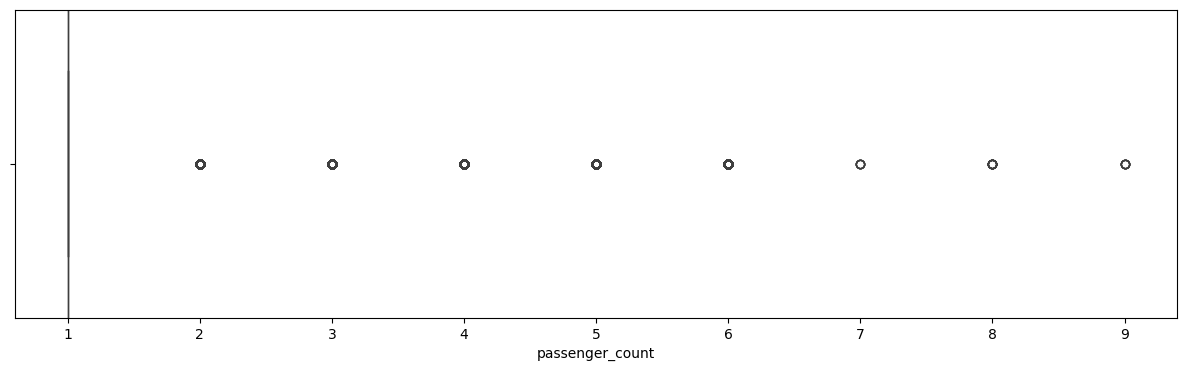

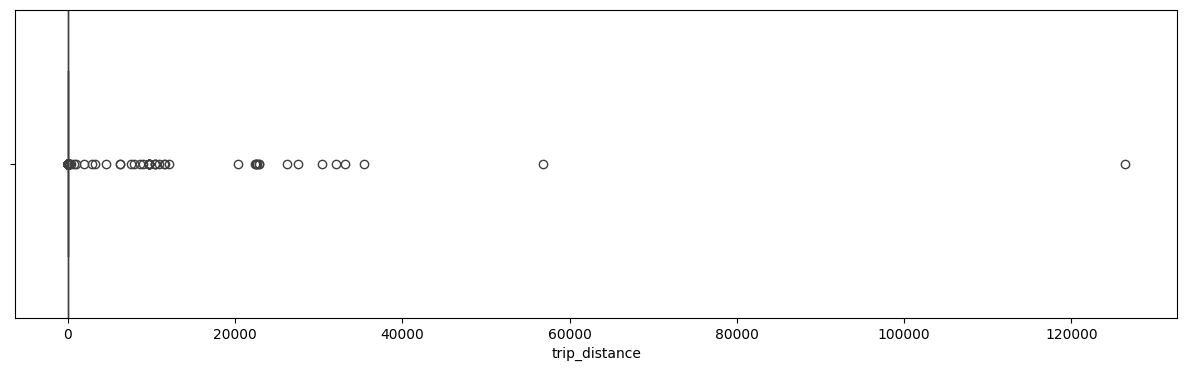

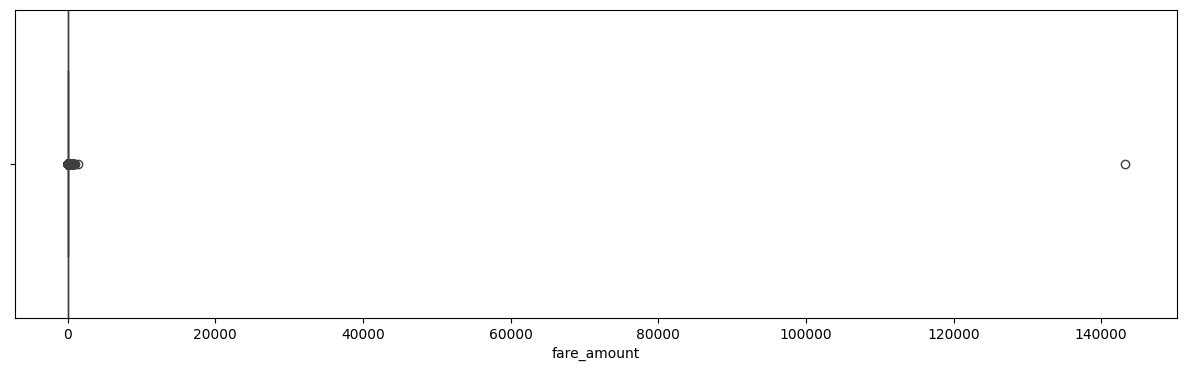

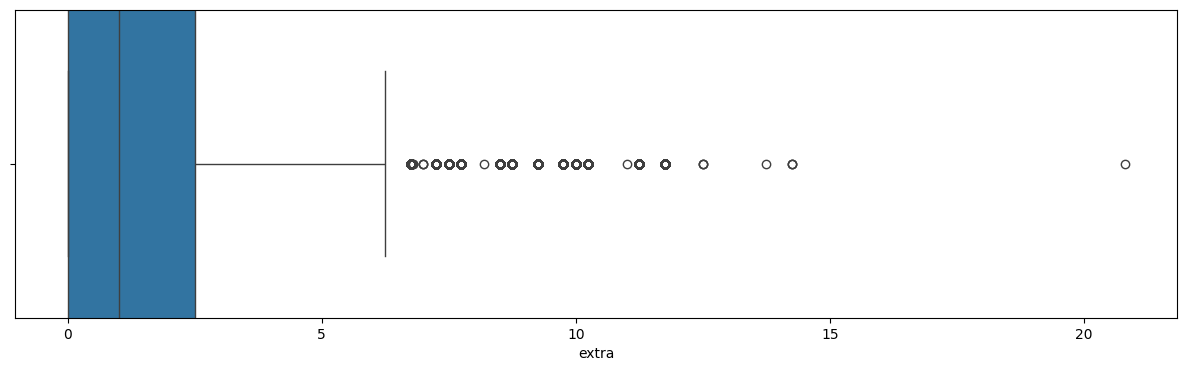

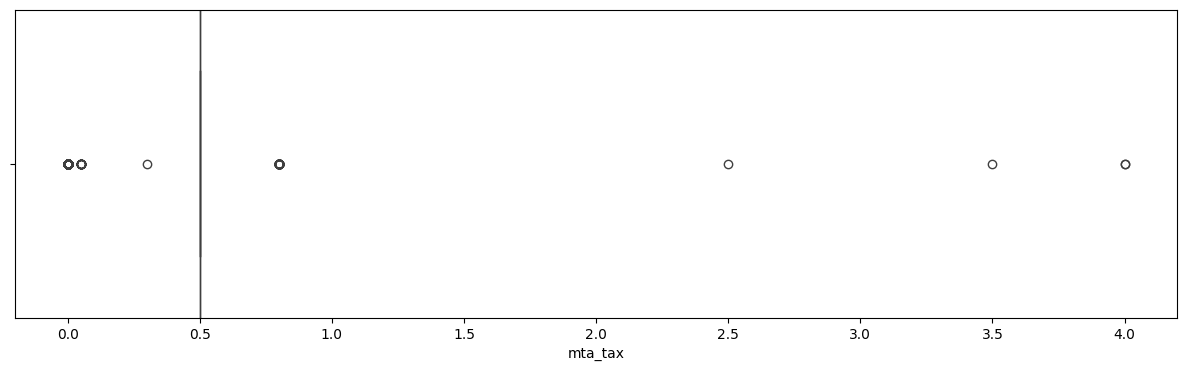

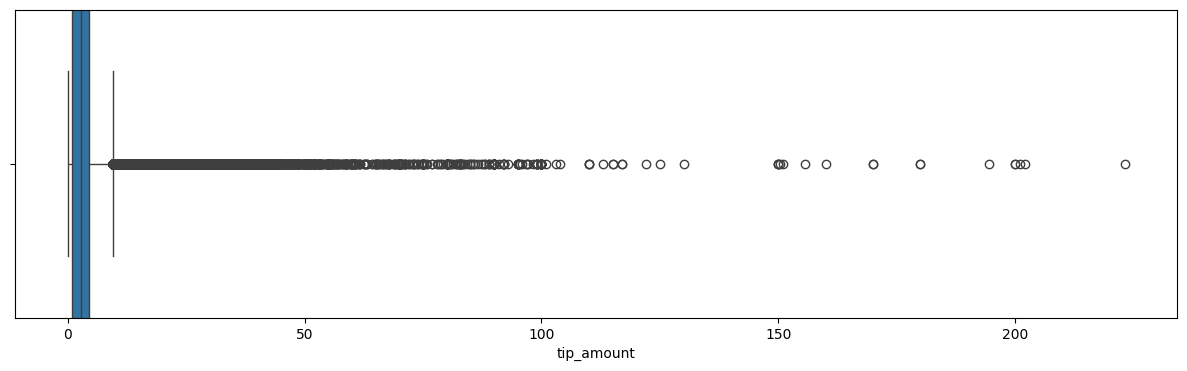

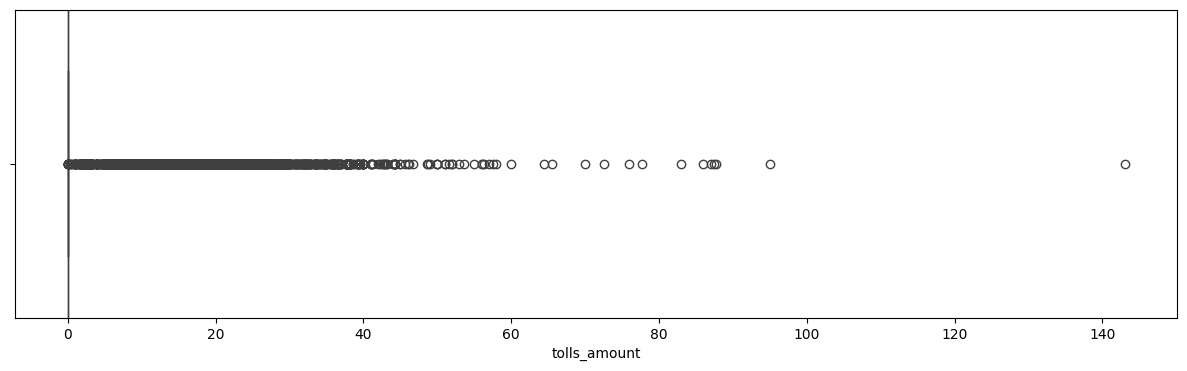

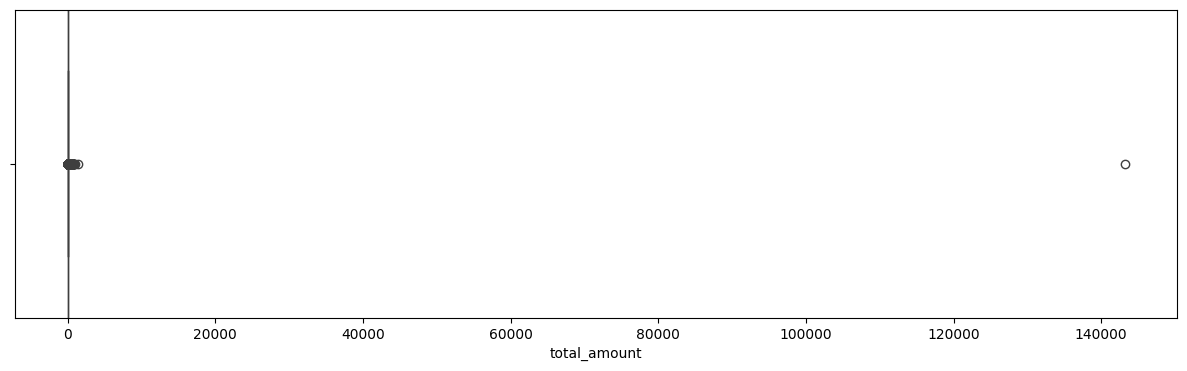

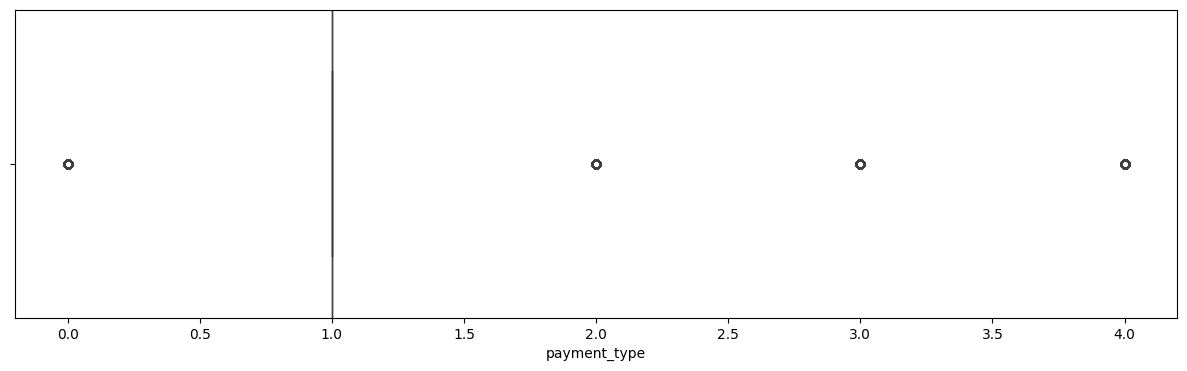

In [61]:
boxplots(df)

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [62]:
# remove passenger_count > 6
df=df[df.passenger_count < 7]

In [63]:
# Continue with outlier handling
#Remove payment_type zero
df=df[df.payment_type != 0]
#Remove the rows which have fare zero and distance also zero but pick up location and drop location is different
df=df[ ~((df.trip_distance == 0) & (df.fare_amount == 0) & (df.PULocationID != df.DOLocationID))]
#Remove rows where the fare is high (> 300) but the trip distance is
df=df[~((df.fare_amount > 300 ) & (df.trip_distance < 10))]
#Remove rows where trip distance is greater than 250
df=df[df.trip_distance<250]
#Removing row where drop off time is lesser than pickup time
df=df[df.tpep_pickup_datetime < df.tpep_dropoff_datetime]
#Removing rows with tip amoutn more than 150% of the fare amount
df=df[(df.tip_amount/df.fare_amount) < 1.5]

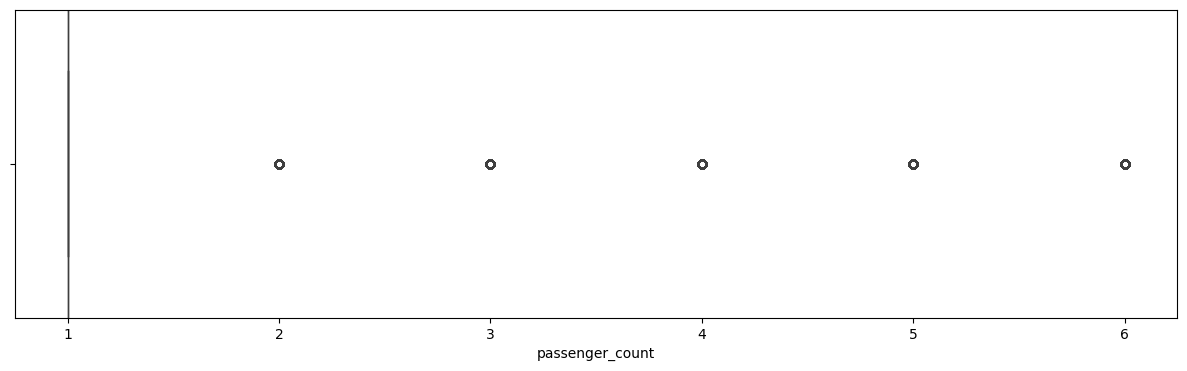

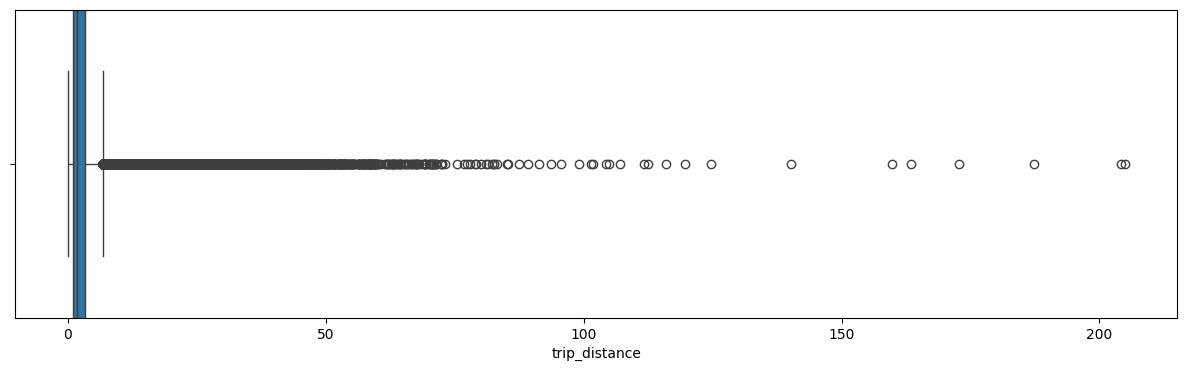

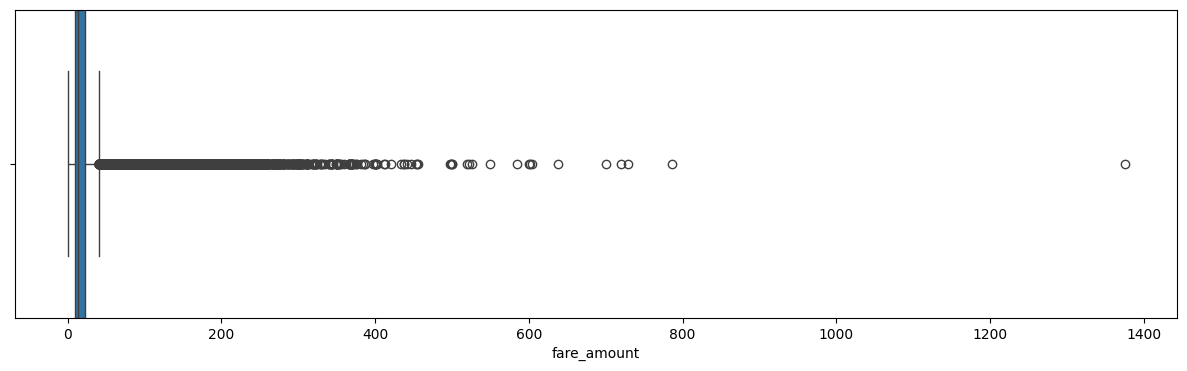

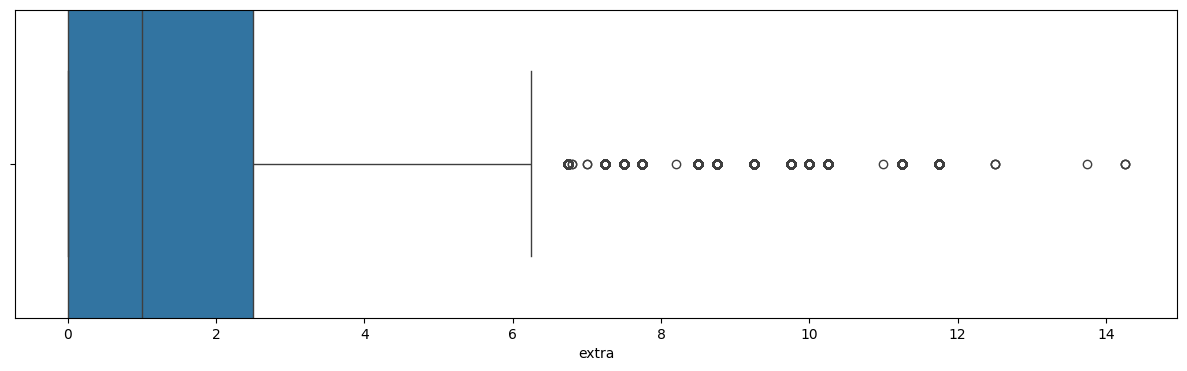

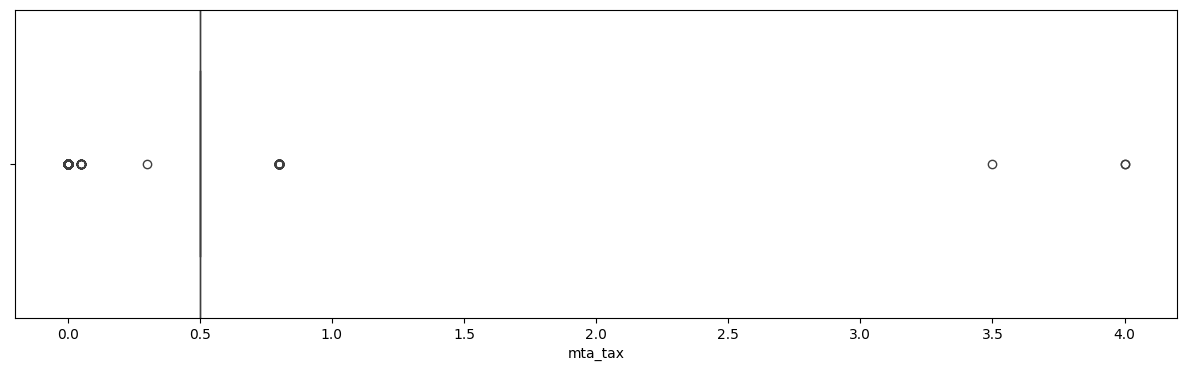

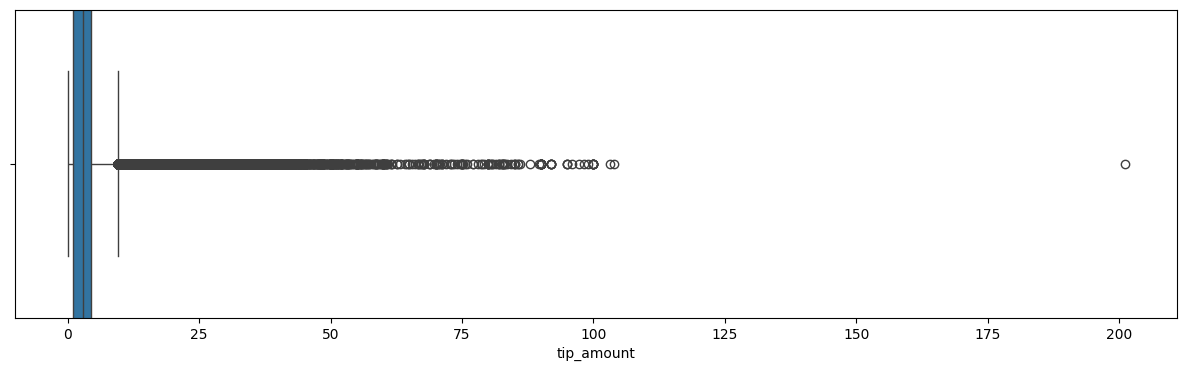

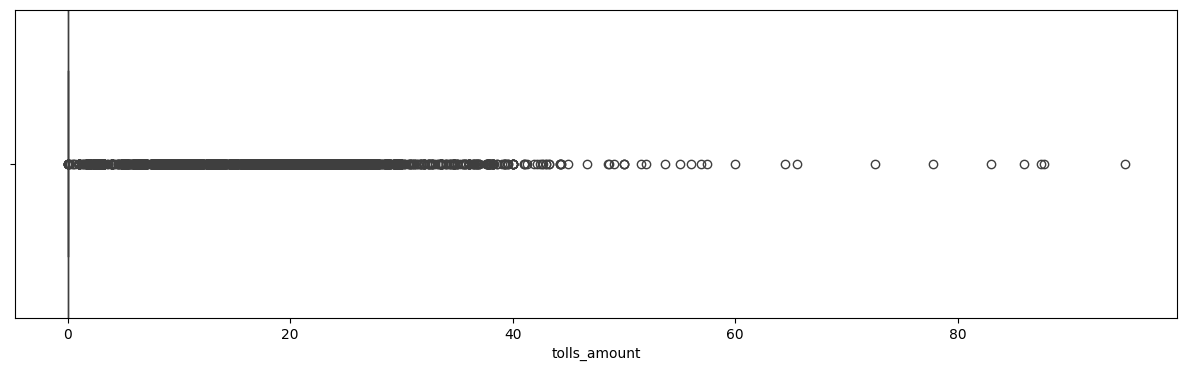

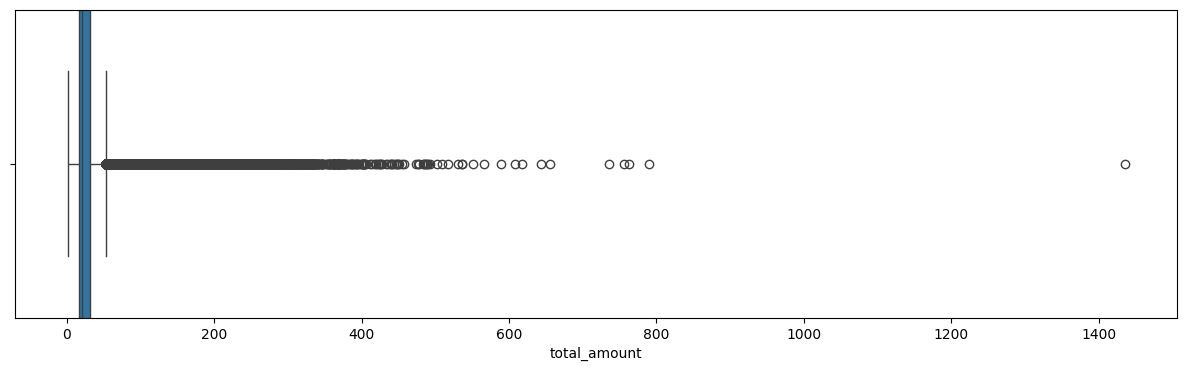

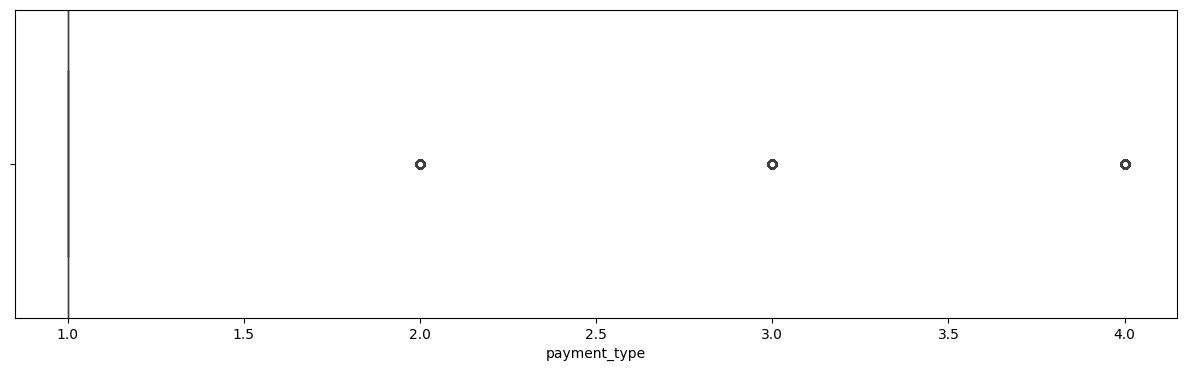

In [64]:
# Do any columns need standardising?
# Most likely standardising is not necessary because we are not going to apply ML algorithms on this data set now.
boxplots(df)



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [65]:
df.columns.tolist()

['index',
 'VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Numerical
* `tpep_dropoff_datetime`: Numerical
* `passenger_count`: Categorical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Categorical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical? Numerical


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

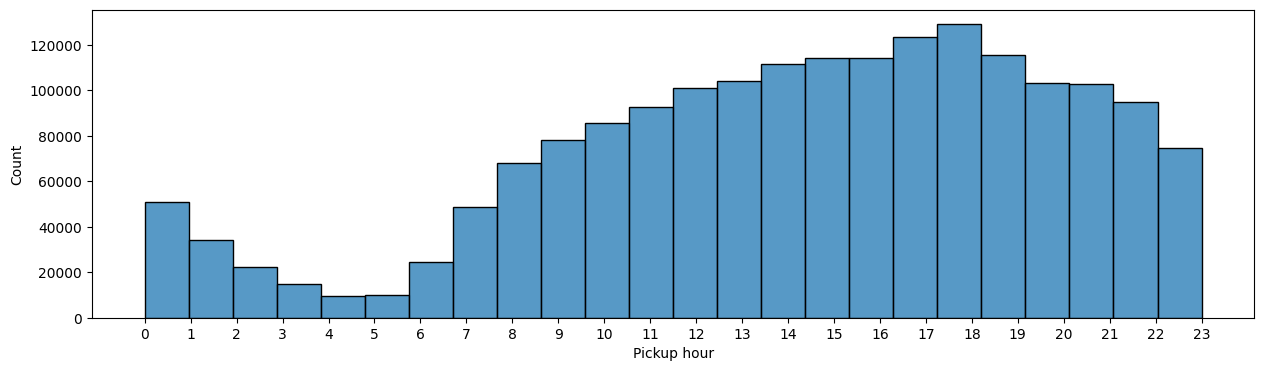

In [66]:
# Find and show the hourly trends in taxi pickups
plt.figure(figsize=(15,4))
sns.histplot(data=df,x=df.tpep_pickup_datetime.dt.hour,bins=24)
plt.xticks(range(0,24))
plt.xlabel('Pickup hour')
plt.show()


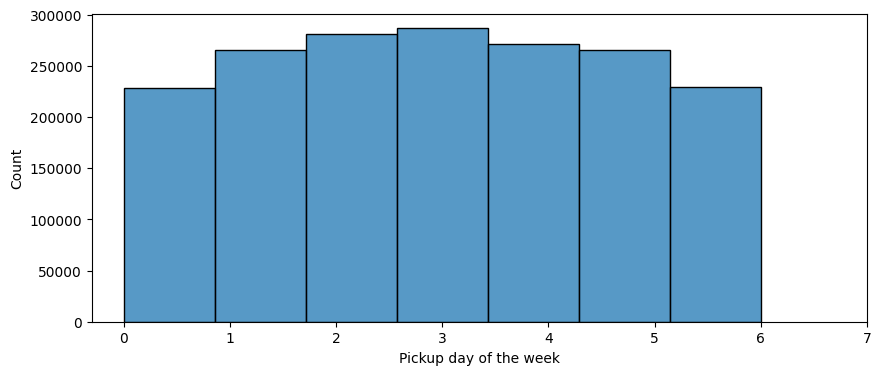

In [67]:
# Find and show the daily trends in taxi pickups (days of the week)

plt.figure(figsize=(10,4))
sns.histplot(data=df,x=df.tpep_pickup_datetime.dt.dayofweek,bins=7)
plt.xticks(range(0,8))
plt.xlabel('Pickup day of the week')
plt.show()

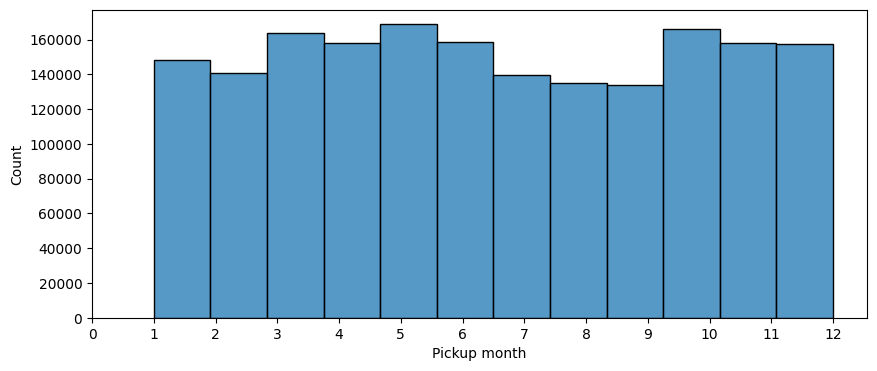

In [68]:
# Show the monthly trends in pickups
plt.figure(figsize=(10,4))
sns.histplot(data=df,x=df.tpep_pickup_datetime.dt.month,bins=12)
plt.xticks(range(0,13))
plt.xlabel('Pickup month')
plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [69]:
# Analyse the above parameters
df[(df.fare_amount==0) | (df.fare_amount<0)]

Empty DataFrame
Columns: [index, VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee]
Index: []

In [70]:
df[(df.tip_amount==0) | (df.tip_amount<0)]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
3           1882         2  2023-01-01 00:27:26   2023-01-01 00:52:20   
7           2240         2  2023-01-01 00:35:52   2023-01-01 00:43:38   
9           4580         2  2023-01-01 00:17:43   2023-01-01 01:03:15   
10          4944         1  2023-01-01 00:53:06   2023-01-01 01:01:57   
13          4511         1  2023-01-01 00:08:49   2023-01-01 00:26:15   
...          ...       ...                  ...                   ...   
1896407  2702915         1  2023-09-30 23:41:35   2023-10-01 00:04:10   
1896408  2702273         2  2023-09-30 23:53:03   2023-10-01 00:13:48   
1896409  2705997         2  2023-09-30 23:37:17   2023-09-30 23:46:07   
1896417  2700485         1  2023-09-30 23:26:31   2023-10-01 00:04:05   
1896419      119         2  2023-08-31 23:56:01   2023-09-01 00:18:41   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
3                    2.0           3.80         1.0           142   
7                    2.0           1.41         1.0           161   
9                    1.0          27.99         1.0           132   
10                   1.0           1.00         1.0           261   
13                   1.0           1.50         1.0           170   
...                  ...            ...         ...           ...   
1896407              1.0           2.80         1.0            79   
1896408              1.0           9.65         1.0           132   
1896409              1.0           0.86         1.0           164   
1896417              2.0          13.20         1.0           164   
1896419              1.0           3.11         1.0           114   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3                 107             2         24.7    1.0      0.5         0.0   
7                 141             2         10.0    1.0      0.5         0.0   
9                 158             2        105.9    1.0      0.5         0.0   
10                231             4          8.6    3.5      0.5         0.0   
13                 43             2         16.3    3.5      0.5         0.0   
...               ...           ...          ...    ...      ...         ...   
1896407           186             3         17.7    3.5      0.5         0.0   
1896408           225             2         39.4    1.0      0.5         0.0   
1896409           233             2          9.3    1.0      0.5         0.0   
1896417            14             2         54.8    3.5      0.5         0.0   
1896419           246             1         21.2    1.0      0.5         0.0   

         tolls_amount  improvement_surcharge  total_amount  \
3                0.00                    1.0         29.70   
7                0.00                    1.0         15.00   
9                6.55                    1.0        118.70   
10               0.00                    1.0         13.60   
13               0.00                    1.0         21.30   
...               ...                    ...           ...   
1896407          0.00                    1.0         22.70   
1896408          0.00                    1.0         43.65   
1896409          0.00                    1.0         14.30   
1896417          0.00                    1.0         59.80   
1896419          0.00                    1.0         26.20   

         congestion_surcharge  Airport_fee  
3                         2.5         0.00  
7                         2.5         0.00  
9                         2.5         1.25  
10                        2.5         0.00  
13                        2.5         0.00  
...                       ...          ...  
1896407                   2.5         0.00  
1896408                   0.0         1.75  
1896409                   2.5         0.00  
1896417                   2.5         0.00  
1896419                   2.5         0.00  

[409078 rows x 19 columns]

In [71]:
df[(df.total_amount==0) | (df.total_amount<0)]

Empty DataFrame
Columns: [index, VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee]
Index: []

In [72]:
df[(df.trip_distance==0) | (df.trip_distance<0)]

index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
27          3326         1  2023-01-01 00:45:06   2023-01-01 00:54:06   
186         3565         2  2023-01-01 00:51:30   2023-01-01 00:55:52   
280         8792         2  2023-01-01 01:34:06   2023-01-01 01:34:14   
305         7788         1  2023-01-01 01:26:38   2023-01-01 01:27:12   
306         8239         2  2023-01-01 01:20:00   2023-01-01 01:20:02   
...          ...       ...                  ...                   ...   
1896083  2700782         2  2023-09-30 23:34:29   2023-09-30 23:49:06   
1896166  2700106         2  2023-09-30 23:06:18   2023-09-30 23:06:29   
1896201  2701485         2  2023-09-30 23:30:41   2023-10-01 00:05:26   
1896378  2701568         2  2023-09-30 23:15:27   2023-09-30 23:22:37   
1896387  2704022         1  2023-09-30 23:13:43   2023-09-30 23:14:07   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
27                   1.0            0.0         1.0            48   
186                  1.0            0.0         1.0           233   
280                  2.0            0.0         5.0           265   
305                  1.0            0.0         5.0           229   
306                  4.0            0.0         5.0           264   
...                  ...            ...         ...           ...   
1896083              1.0            0.0         1.0           264   
1896166              1.0            0.0         1.0           132   
1896201              4.0            0.0         1.0           264   
1896378              2.0            0.0         1.0           264   
1896387              1.0            0.0         5.0           148   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
27                 48             2          8.6    3.5      0.5        0.00   
186               140             1          5.8    1.0      0.5        2.16   
280               265             1         50.0    0.0      0.0       10.20   
305               229             1          5.0    0.0      0.0        0.00   
306               264             1         45.0    0.0      0.0        0.80   
...               ...           ...          ...    ...      ...         ...   
1896083           264             1         12.8    1.0      0.5        4.59   
1896166           132             4          3.0    1.0      0.5        0.00   
1896201           264             2         26.8    1.0      0.5        0.00   
1896378           264             1          7.9    1.0      0.5        1.55   
1896387           148             1         10.0    0.0      0.0        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
27                0.0                    1.0         13.60   
186               0.0                    1.0         12.96   
280               0.0                    1.0         61.20   
305               0.0                    1.0          6.00   
306               0.0                    1.0         46.80   
...               ...                    ...           ...   
1896083           0.0                    1.0         19.89   
1896166           0.0                    1.0          7.25   
1896201           0.0                    1.0         29.30   
1896378           0.0                    1.0         14.45   
1896387           0.0                    1.0         11.00   

         congestion_surcharge  Airport_fee  
27                        2.5         0.00  
186                       2.5         0.00  
280                       0.0         0.00  
305                       0.0         0.00  
306                       0.0         0.00  
...                       ...          ...  
1896083                   0.0         0.00  
1896166                   0.0         1.75  
1896201                   0.0         0.00  
1896378                   2.5         0.00  
1896387                   0.0         0.00  

[21614 rows x 19 columns]

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [73]:
# Create a df with non zero entries for the selected parameters.
#Yes the zero values for fare_amount and total_amount can be removed as they do not have any value addition to the dataset
# Zero or negative values for trip_distance also can be removed
#However tip_amount zero should not be removed because tip is not mandatory; as it depends on the client

df_filtered=df[(df.fare_amount>0) & (df.total_amount > 0) & (df.trip_distance > 0) ]


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [74]:
# Group data by month and analyse monthly revenue
# Display the aggregated total_amount per month
df_filtered.groupby(by=df_filtered.tpep_pickup_datetime.dt.month)[['total_amount']].sum()

total_amount
tpep_pickup_datetime              
1                       3992663.60
2                       3773994.80
3                       4552436.34
4                       4464913.32
5                       4871714.97
6                       4581650.00
7                       3982146.80
8                       3878083.69
9                       3957971.23
10                      4882813.26
11                      4544855.02
12                      4526833.82

<Figure size 1500x400 with 0 Axes>

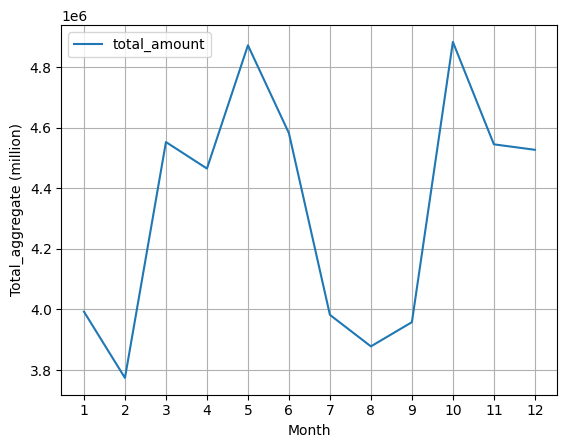

In [75]:
# PLot the aggregated total_amount per month
plt.figure(figsize=(15,4))
df_filtered.groupby(by=df_filtered.tpep_pickup_datetime.dt.month)[['total_amount']].sum().plot(xlabel='Month',ylabel='Total_aggregate (million)',grid=True)
plt.xticks(range(1,13))
plt.show()
#Below plot shows that May and October have the most collection
#And Feb and Aug have the low collections

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [76]:
# Calculate proportion of each quarter
# Display the aggregated total_amount per quarter
df_filtered.groupby(by=df_filtered.tpep_pickup_datetime.dt.quarter)[['total_amount']].sum()


total_amount
tpep_pickup_datetime              
1                      12319094.74
2                      13918278.29
3                      11818201.72
4                      13954502.10

<Figure size 1500x400 with 0 Axes>

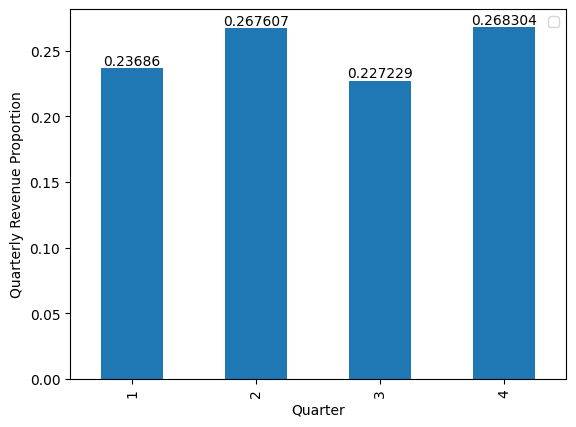

In [77]:
#Show the proportion of each quarter of the year in the revenue
plt.figure(figsize=(15,4))
ax=df_filtered.groupby(by=df_filtered.tpep_pickup_datetime.dt.quarter)[['total_amount']]\
    .sum()\
    .agg(lambda x: x/x.sum()).reset_index().plot(x='tpep_pickup_datetime',y='total_amount',kind='bar')
plt.xlabel("Quarter")
plt.ylabel("Quarterly Revenue Proportion")
plt.legend("")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

<Figure size 1500x400 with 0 Axes>

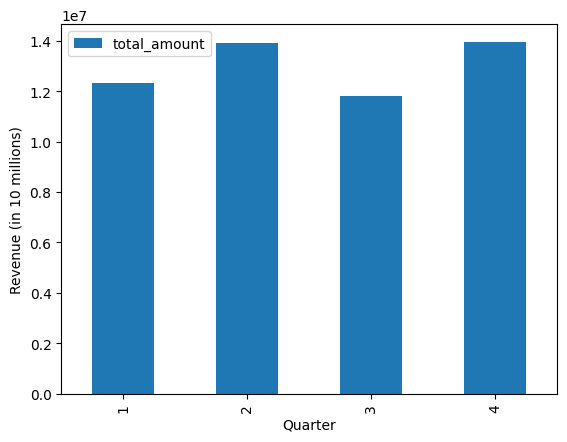

In [78]:
#Plot the quarterly revenue
plt.figure(figsize=(15,4))
df_filtered.groupby(by=df_filtered.tpep_pickup_datetime.dt.quarter)[['total_amount']].sum().reset_index().plot(x='tpep_pickup_datetime',y='total_amount',kind='bar')
plt.xlabel('Quarter')
plt.ylabel('Revenue (in 10 millions)')
plt.show()

x**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

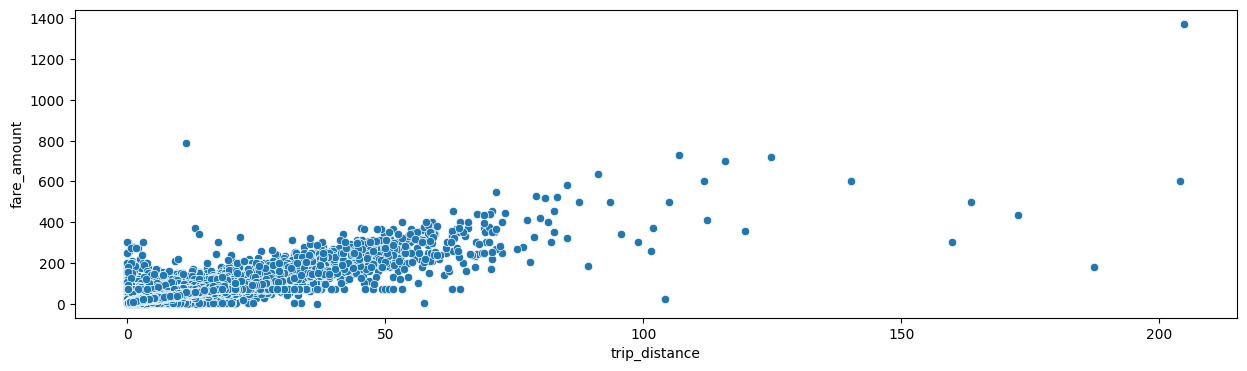

In [79]:
# Show how trip fare is affected by distance
plt.figure(figsize=(15,4))
sns.scatterplot(data=df_filtered,x='trip_distance',y='fare_amount')
plt.show()
#Below plot depicts positive correlation between trip distance and fare_amount

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

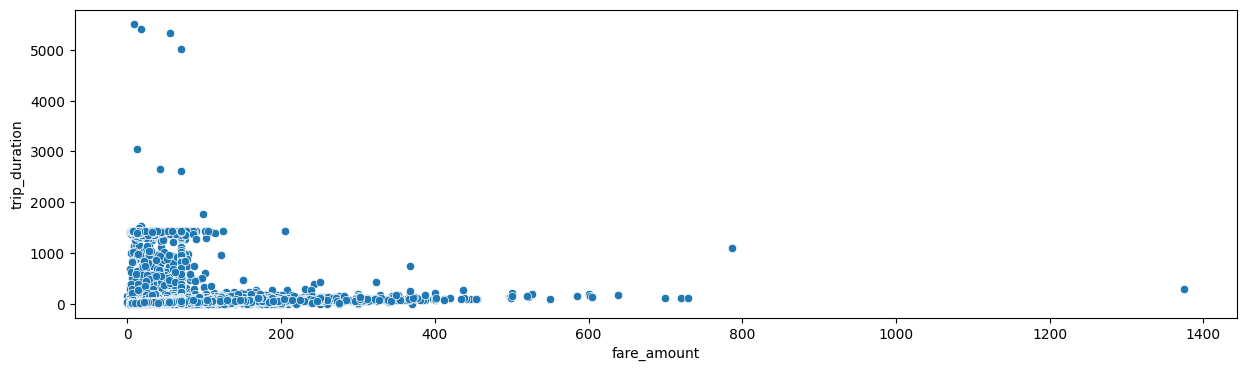

In [80]:
# Show relationship between fare and trip duration
#get trip duration
df_filtered['trip_duration']=(df_filtered.tpep_dropoff_datetime-df_filtered.tpep_pickup_datetime).apply(lambda x: x.total_seconds()/60.0)
#plot fare_amount vs trip_duration
plt.figure(figsize=(15,4))
sns.scatterplot(data=df_filtered,x='fare_amount',y='trip_duration')
plt.show()
#From below plot there is no specific pattern that can be seen between fare_amount and trip_duration

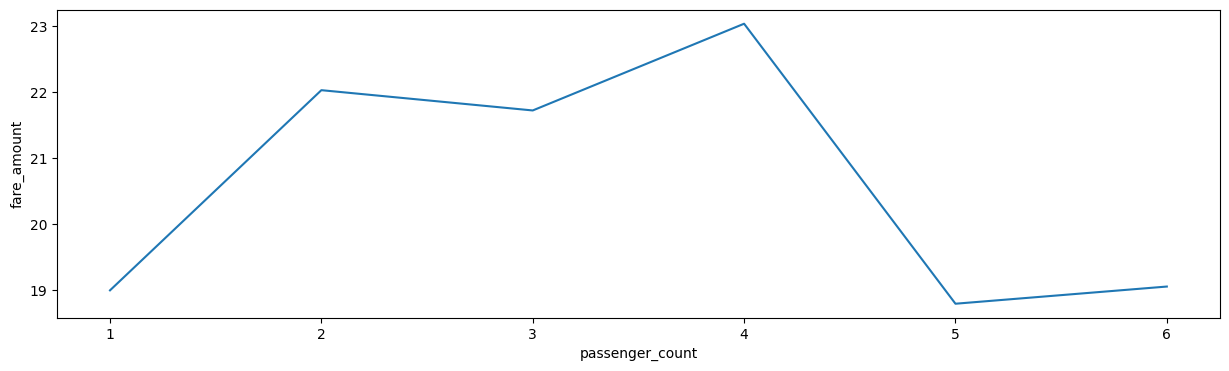

In [81]:
# Show relationship between fare and number of passengers
#plot fare_amount vs passenger_count
plt.figure(figsize=(15,4))
sns.lineplot(data=df_filtered.groupby(by='passenger_count')[['fare_amount']].mean(),x='passenger_count',y='fare_amount')
plt.show()

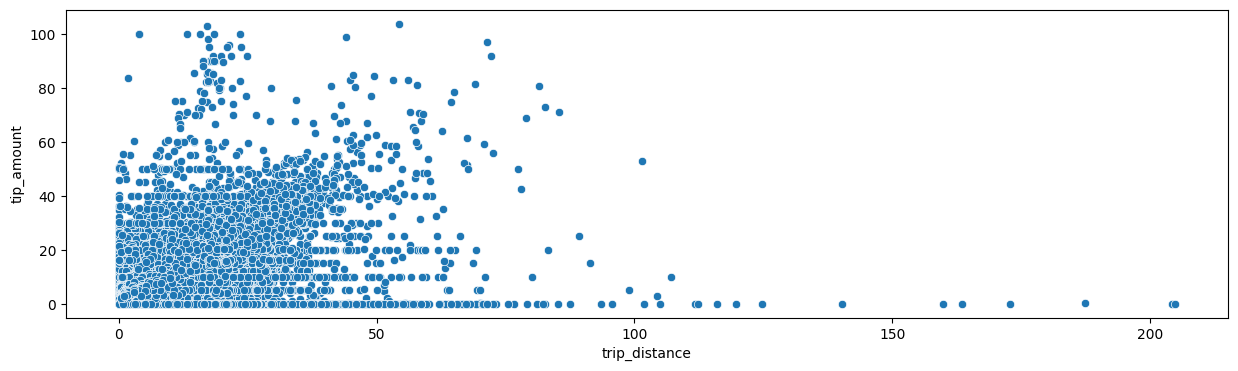

In [82]:
# Show relationship between tip and trip distance

plt.figure(figsize=(15,4))
sns.scatterplot(data=df_filtered,x='trip_distance',y='tip_amount')
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

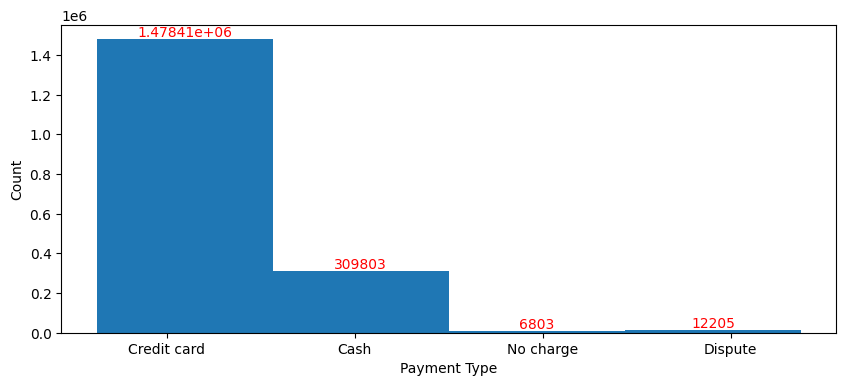

In [83]:
# Analyse the distribution of different payment types (payment_type).

plt.figure(figsize=(10,4))
values, bins, bars=plt.hist(df_filtered.payment_type,bins=4)
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.xticks(ticks=[1.3,2.1,2.9,3.7],labels=['Credit card', 'Cash', 'No charge', 'Dispute'])
plt.bar_label(bars, fontsize=10, color='red')
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [84]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [85]:
import geopandas as gpd


# Read the shapefile using geopandas
zones =gpd.read_file('/content/drive/My Drive/ML/EDA/taxi_zones/taxi_zones.shp')
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


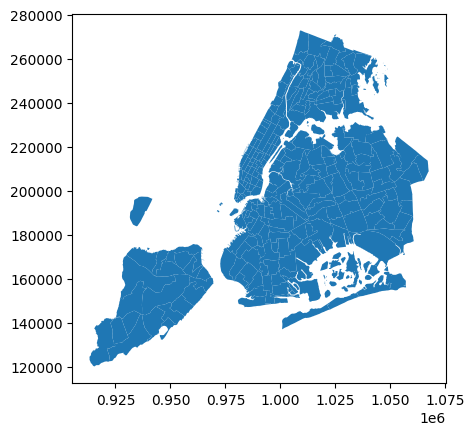

In [86]:
print(zones.info())
zones.plot()
plt.show()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [87]:
# Merge zones and trip records using locationID and PULocationID
df_filtered_zone=pd.merge(left=df_filtered,right=zones,left_on=['PULocationID'],right_on=['LocationID'])
df_filtered_zone


index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0           3703         2  2023-01-01 00:31:50   2023-01-01 00:44:17   
1           4166         2  2023-01-01 00:10:50   2023-01-01 00:24:12   
2           3847         2  2023-01-01 00:25:37   2023-01-01 00:34:52   
3           1882         2  2023-01-01 00:27:26   2023-01-01 00:52:20   
4           4335         1  2023-01-01 00:55:02   2023-01-01 00:59:57   
...          ...       ...                  ...                   ...   
1791084  2706224         1  2023-09-30 23:44:51   2023-09-30 23:49:05   
1791085  2702893         2  2023-09-30 23:11:05   2023-09-30 23:18:42   
1791086  2700485         1  2023-09-30 23:26:31   2023-10-01 00:04:05   
1791087  2705104         2  2023-09-30 23:19:47   2023-09-30 23:33:36   
1791088      119         2  2023-08-31 23:56:01   2023-09-01 00:18:41   

         passenger_count  trip_distance  RatecodeID  PULocationID  \
0                    2.0           2.85         1.0           263   
1                    4.0           1.32         1.0            90   
2                    1.0           3.17         1.0            79   
3                    2.0           3.80         1.0           142   
4                    1.0           0.60         1.0           237   
...                  ...            ...         ...           ...   
1791084              3.0           0.50         1.0           158   
1791085              1.0           1.09         1.0           161   
1791086              2.0          13.20         1.0           164   
1791087              1.0           2.97         1.0           231   
1791088              1.0           3.11         1.0           114   

         DOLocationID  payment_type  ...  congestion_surcharge  Airport_fee  \
0                  41             1  ...                   2.5          0.0   
1                 137             1  ...                   2.5          0.0   
2                 141             1  ...                   2.5          0.0   
3                 107             2  ...                   2.5          0.0   
4                 237             1  ...                   2.5          0.0   
...               ...           ...  ...                   ...          ...   
1791084            68             1  ...                   2.5          0.0   
1791085           162             1  ...                   2.5          0.0   
1791086            14             2  ...                   2.5          0.0   
1791087            68             1  ...                   2.5          0.0   
1791088           246             1  ...                   2.5          0.0   

         trip_duration  OBJECTID  Shape_Leng  Shape_Area  \
0            12.450000       263    0.037017    0.000066   
1            13.366667        90    0.030759    0.000055   
2             9.250000        79    0.042625    0.000108   
3            24.900000       142    0.038176    0.000076   
4             4.916667       237    0.042213    0.000096   
...                ...       ...         ...         ...   
1791084       4.233333       158    0.054810    0.000186   
1791085       7.616667       161    0.035804    0.000072   
1791086      37.566667       164    0.035772    0.000056   
1791087      13.816667       231    0.063420    0.000167   
1791088      22.666667       114    0.031727    0.000047   

                                  zone  LocationID    borough  \
0                       Yorkville West         263  Manhattan   
1                             Flatiron          90  Manhattan   
2                         East Village          79  Manhattan   
3                  Lincoln Square East         142  Manhattan   
4                Upper East Side South         237  Manhattan   
...                                ...         ...        ...   
1791084  Meatpacking/West Village West         158  Manhattan   
1791085                 Midtown Center         161  Manhattan   
1791086                  Midtown South         164

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [88]:
# Group data by location and calculate the number of trips
df_filtered_location_count=df_filtered_zone.groupby(by='LocationID')[['index']].count()
df_filtered_location_count.columns=['Count']
df_filtered_location_count.reset_index()

LocationID  Count
0             1     44
1             2      2
2             3     31
3             4   1807
4             5      9
..          ...    ...
247         259     35
248         260    298
249         261   9533
250         262  23492
251         263  34627

[252 rows x 2 columns]

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [89]:
# Merge trip counts back to the zones GeoDataFrame
zone_count=pd.merge(left=zones,right=df_filtered_location_count,on=['LocationID'])
zone_count


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
248       259    0.126750    0.000395       Woodlawn/Wakefield         259   
249       260    0.133514    0.000422                 Woodside         260   
250       261    0.027120    0.000034       World Trade Center         261   
251       262    0.049064    0.000122           Yorkville East         262   
252       263    0.037017    0.000066           Yorkville West         263   

           borough                                           geometry  Count  
0              EWR  POLYGON ((933100.918 192536.086, 933091.011 19...     44  
1           Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...      2  
2            Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...     31  
3        Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   1807  
4    Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...      9  
..             ...                                                ...    ...  
248          Bronx  POLYGON ((1025414.782 270986.139, 1025138.624 ...     35  
249         Queens  POLYGON ((1011466.966 216463.005, 1011545.889 ...    298  
250      Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...   9533  
251      Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  23492  
252      Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...  34627  

[253 rows x 8 columns]

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

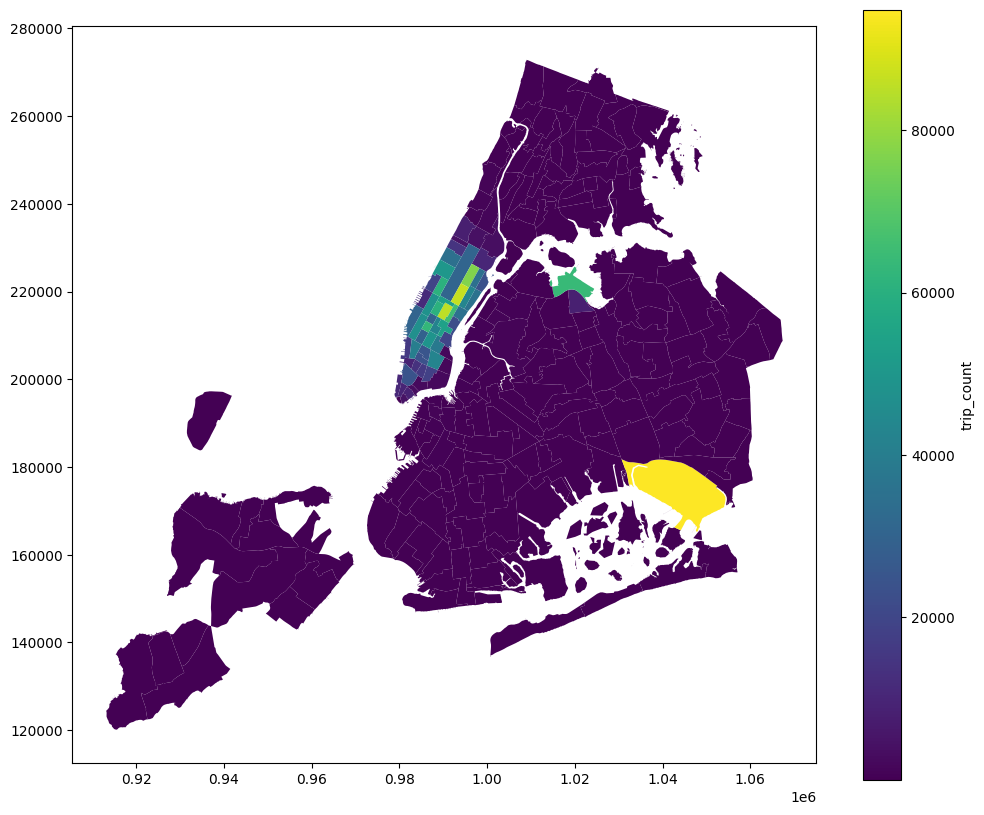

In [90]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
zone_count.plot(column = 'Count',
           ax = ax,
           legend = True,
           legend_kwds = {'label': "trip_count", 'orientation': "vertical"})
plt.show()


In [91]:
# can you try displaying the zones DF sorted by the number of trips?

zone_count.sort_values(by=['Count'],ascending=False)

OBJECTID  Shape_Leng  Shape_Area                    zone  LocationID  \
124       132    0.245479    0.002038             JFK Airport         132   
227       237    0.042213    0.000096   Upper East Side South         237   
153       161    0.035804    0.000072          Midtown Center         161   
226       236    0.044252    0.000103   Upper East Side North         236   
154       162    0.035270    0.000048            Midtown East         162   
..        ...         ...         ...                     ...         ...   
148       156    0.144477    0.001052         Mariners Harbor         156   
175       184    0.260816    0.001989         Pelham Bay Park         184   
178       187    0.126868    0.000421           Port Richmond         187   
164       172    0.118476    0.000658  New Dorp/Midland Beach         172   
240       251    0.137711    0.000626             Westerleigh         251   

           borough                                           geometry  Count  
124         Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...  94846  
227      Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...  86389  
153      Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...  85375  
226      Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...  77039  
154      Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...  65227  
..             ...                                                ...    ...  
148  Staten Island  MULTIPOLYGON (((934327.461 174416.463, 934330....      1  
175          Bronx  MULTIPOLYGON (((1037536.693 262105.37, 1037634...      1  
178  Staten Island  MULTIPOLYGON (((946964.115 173161.64, 946977.8...      1  
164  Staten Island  POLYGON ((960204.812 146820.751, 960103.437 14...      1  
240  Staten Island  POLYGON ((947868.004 169247.734, 948000.981 16...      1  

[253 rows x 8 columns]

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


In [92]:
#Summary on findings related to temporal, financial and geographical analysis:
# 1. Busiest hour is 18:00 on any day, day wise Wednesday is the busiest and in terms of months it is October, May and March.
#2. Revenue wise, it matches the busiest months mentioned above. Maximum revenue is in October, followed by May and then March.
#3. Quarterly revenue is maximum in Q4 but Q2 being quite close.
#4. Fares had a positive correlation with trip distance. However did not see much of a correlation between fare and trip duration. In terms of fare ~ passenger counts, average fare increases with passenger count till 4 and then falls.
#5. There was slight positive correlation between trip distance and tip amount (ignored high tip amounts for low trip distance as they are unlikely)
#6. JFK Airport happens to be the busiest zone of all, followed by Upper East Side South (Manhattan) and Midtown Centre (Manhattan)

#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [93]:
# Find routes which have the slowest speeds at different times of the day
#First create a hour column and day (dayofweek) columns (to be used later)
df_filtered['hour']=df_filtered.tpep_pickup_datetime.dt.hour
df_filtered['day']=df_filtered.tpep_pickup_datetime.dt.day_of_week
# PULocationID and DOLocationID depict a route
df_speed=df_filtered[df_filtered.PULocationID != df_filtered.DOLocationID]\
    .groupby(by=['PULocationID','DOLocationID','hour'])\
    .agg({'trip_distance': 'mean','trip_duration': 'mean'}).reset_index()
df_speed['avg_speed'] = df_speed['trip_distance']/df_speed['trip_duration']
df_speed.sort_values(by=['avg_speed'])
#Below are some of the slowest routes at that given hour

PULocationID  DOLocationID  hour  trip_distance  trip_duration  \
100370           232            65    13           0.49    5522.433333   
112810           243           264    17           0.18    1389.550000   
32610            100             7     8           0.22     334.433333   
6200              40            65    21           1.12    1434.433333   
38628            113           235    22           0.28     349.233333   
...              ...           ...   ...            ...            ...   
64601            145           213    11           6.40       0.350000   
91558            216           264    13           1.01       0.050000   
5404              33            72    13           4.10       0.200000   
91557            216           264     4           0.75       0.033333   
123604           264            70    14           9.94       0.166667   

        avg_speed  
100370   0.000089  
112810   0.000130  
32610    0.000658  
6200     0.000781  
38628    0.000802  
...           ...  
64601   18.285714  
91558   20.200000  
5404    20.500000  
91557   22.500000  
123604  59.640000  

[124794 rows x 6 columns]

How does identifying high-traffic, high-demand routes help us? It would help us assign more cabs for high demand hours and also think of alternate routes to avoid high traffic

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

<Figure size 1500x400 with 0 Axes>

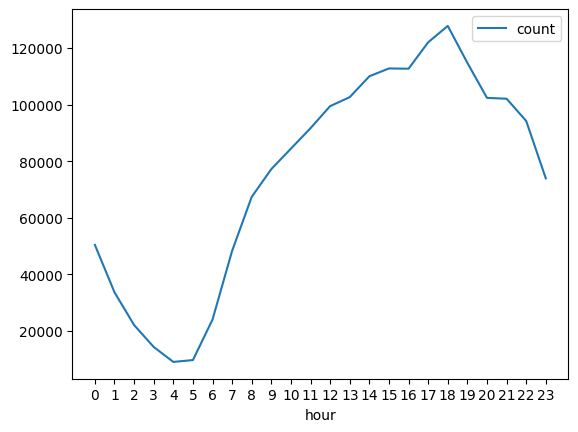

In [94]:
# Visualise the number of trips per hour and find the busiest hour

df_count_hour=df_filtered.groupby(by='hour')[['index']].count().reset_index()
df_count_hour.columns=['hour','count']
plt.figure(figsize=(15,4))
df_count_hour.plot(x='hour',y='count',xticks=np.arange(0,24))
plt.show()

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [95]:
# Scale up the number of trips
# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction =0.05
#get the top 5 busiest hours
df_count_hour_top5=df_count_hour.sort_values(by='count', ascending=False).head(5)
df_count_hour_top5['scaled_count']=df_count_hour_top5['count']*(1/sample_fraction)
df_count_hour_top5



hour   count  scaled_count
18    18  127811     2556220.0
17    17  122032     2440640.0
19    19  114754     2295080.0
15    15  112785     2255700.0
16    16  112689     2253780.0

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

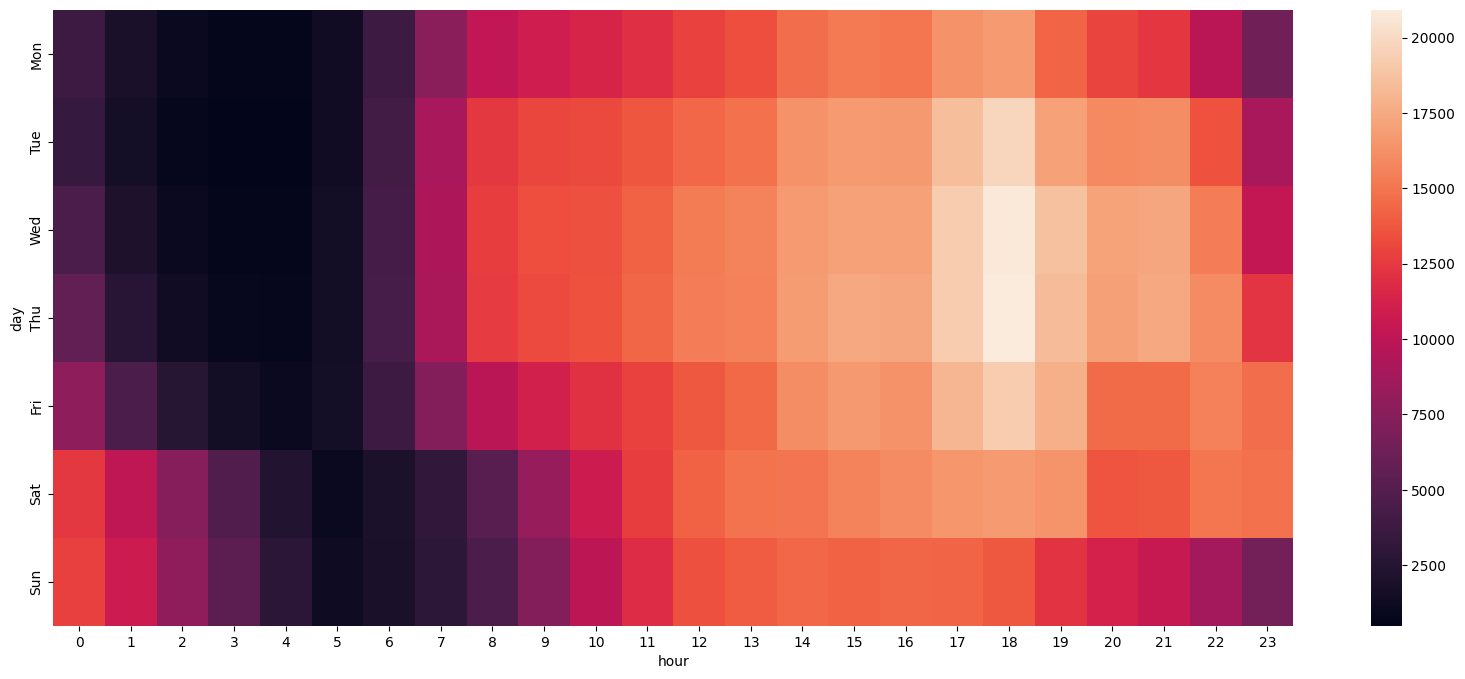

In [96]:
plt.figure(figsize=(20,8))
pvt=pd.pivot_table(data=df_filtered,values='index',columns='hour',index='day',aggfunc=np.count_nonzero)
sns.heatmap(pvt,yticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?
From the above heatmap it is clear that busiest times are between 17:00 hrs - 19:00 hrs on Wednesdays and Thursdays.
Weekends on are not as busy.
It is worth noticing that weekends during early hours (00:00 to 02:00) it is busier that other days for the same time.
Busy and quiet hours determination will help us allocate resources accordingly thereby reducing idle time.

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [97]:
# Find top 10 pickup and dropoff zones

#adding the following columns to be used later for our analysis:
# hour and day(dayofweek) extracted from pick up time
# hour_drop and day_drop(dayofweek) extracted from drop off time
df_filtered['hour']=df_filtered.tpep_pickup_datetime.dt.hour
df_filtered['day']=df_filtered.tpep_pickup_datetime.dt.day_of_week
df_filtered['hour_drop']=df_filtered.tpep_dropoff_datetime.dt.hour
df_filtered['day_drop']=df_filtered.tpep_dropoff_datetime.dt.day_of_week
# Join with zone with key as PULocationID to get pick up zones (zone_x)
df_filtered_zone=pd.merge(left=df_filtered,right=zones,left_on=['PULocationID'],right_on=['LocationID'])
# Join with zone again with key as DOLocationID to get drop off zones (zone_y)
df_filtered_zone=pd.merge(left=df_filtered_zone,right=zones,left_on=['DOLocationID'],right_on=['LocationID'])



In [98]:
# top ten pick up zones
df_pu_zones=df_filtered_zone.groupby(by='zone_x')[['index']].count().reset_index().sort_values(by='index',ascending=False)
df_pu_zones.columns=['zone','count']
df_pu_zones.head(10)

zone  count
118                   JFK Airport  91210
224         Upper East Side South  86177
150                Midtown Center  85102
223         Upper East Side North  76824
151                  Midtown East  65010
128             LaGuardia Airport  62713
174  Penn Station/Madison Sq West  62625
132           Lincoln Square East  60367
217     Times Sq/Theatre District  60291
159                   Murray Hill  53873

In [99]:
# top ten drop off zones
df_do_zones=df_filtered_zone.groupby(by='zone_y')[['index']].count().reset_index().sort_values(by='index',ascending=False)
df_do_zones.columns=['zone','count']
df_do_zones.head(10)

zone  count
229      Upper East Side North  80682
230      Upper East Side South  77036
154             Midtown Center  70906
223  Times Sq/Theatre District  55757
163                Murray Hill  53788
155               Midtown East  51740
135        Lincoln Square East  51043
232      Upper West Side South  50866
134            Lenox Hill West  48185
64                East Chelsea  45821

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [100]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
df_pu_do_zones=pd.merge(left=df_pu_zones,right=df_do_zones,on='zone')
df_pu_do_zones.columns=['zone','pucount','docount']
df_pu_do_zones['ratio']=df_pu_do_zones['pucount']/df_pu_do_zones['docount']
df_pu_do_zones_sorted=df_pu_do_zones.sort_values(by='ratio',ascending=False)
# top 10 pickup/dropoff ratio
print('Top 10 pickup/dropoff ratio')
print(df_pu_do_zones_sorted.head(10))
# bottom 10 pickup/dropoff ratio
print('Bottom 10 pickup/dropoff ratio')
print(df_pu_do_zones_sorted.tail(10))


Top 10 pickup/dropoff ratio
                            zone  pucount  docount     ratio
46                 East Elmhurst     8059      847  9.514758
0                    JFK Airport    91210    19264  4.734738
5              LaGuardia Airport    62713    21730  2.886010
6   Penn Station/Madison Sq West    62625    39721  1.576622
30       Greenwich Village South    23907    17394  1.374439
24                  Central Park    30474    22181  1.373879
18                  West Village    39983    30187  1.324511
4                   Midtown East    65010    51740  1.256475
2                 Midtown Center    85102    70906  1.200209
26              Garment District    29744    25026  1.188524
Bottom 10 pickup/dropoff ratio
                                    zone  pucount  docount     ratio
238          Heartland Village/Todt Hill        2       41  0.048780
231                     Inwood Hill Park        5      103  0.048544
126                       Bushwick South       81     1767  0.0

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [101]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
# top ten pick up zones
df_pu_zones_11_5=df_filtered_zone[df_filtered_zone.hour.isin([23,0,1,2,3,4,5])].groupby(by='zone_x')[['index']].count().reset_index().sort_values(by='index',ascending=False)
df_pu_zones_11_5.columns=['zone','count']
print('Top 10 pickup zones between 11 PM and 5 AM')
print(df_pu_zones_11_5.head(10))
df_do_zones_11_5=df_filtered_zone[df_filtered_zone.hour_drop.isin([23,0,1,2,3,4,5])].groupby(by='zone_y')[['index']].count().reset_index().sort_values(by='index',ascending=False)
df_do_zones_11_5.columns=['zone','count']
print('Top 10 dropoff zones between 11 PM and 5 AM')
print(df_do_zones_11_5.head(10))


Top 10 pickup zones between 11 PM and 5 AM
                             zone  count
69                   East Village  15377
108                   JFK Airport  13672
217                  West Village  12320
41                   Clinton East  10245
127               Lower East Side   9546
96        Greenwich Village South   8658
199     Times Sq/Theatre District   8036
160  Penn Station/Madison Sq West   6860
141                 Midtown South   6042
58                   East Chelsea   5924
Top 10 dropoff zones between 11 PM and 5 AM
                          zone  count
75                East Village   8751
45                Clinton East   7366
161                Murray Hill   6622
64                East Chelsea   6167
99                    Gramercy   6081
132            Lenox Hill West   5741
253             Yorkville West   5436
239               West Village   5231
220  Times Sq/Theatre District   5074
229      Upper West Side South   4827


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [102]:
# Filter for night hours (11 PM to 5 AM)
# Creating a column daytime which is set to N if pickup time is between 11 PM and 5 AM else Y
df_filtered['day_or_night']=df_filtered.apply(lambda x : 'Night' if x.hour in [23,0,1,2,3,4,5] else 'Day',axis=1)
# Display revenue comparision between daytime and nighttime hours
df_filtered.groupby(by='day_or_night')[['total_amount']].sum().reset_index()


day_or_night  total_amount
0          Day   45771264.78
1        Night    6238812.07

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

   passenger_count  avg_fare_per_mile_per_person
0              1.0                     16.625373
1              2.0                      9.327839
2              3.0                      5.831529
3              4.0                      5.939673
4              5.0                      2.749163
5              6.0                      2.215299


<Figure size 1500x400 with 0 Axes>

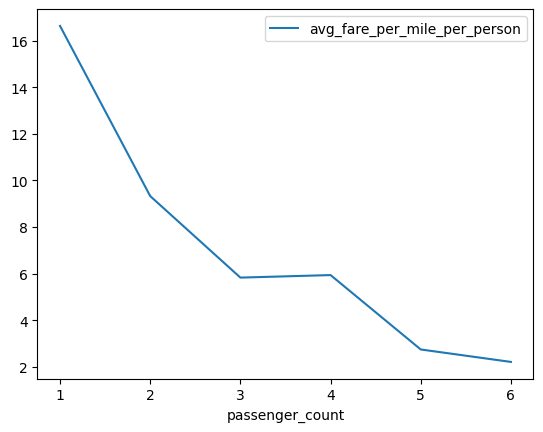

In [103]:
# Analyse the fare per mile per passenger for different passenger counts
# Get total fare per mile
df_filtered['fare_per_mile']=df_filtered.total_amount/df_filtered.trip_distance
df_avg_fare_per_mile=df_filtered.groupby(by='passenger_count')['fare_per_mile'].mean().reset_index()
df_avg_fare_per_mile.columns=['passenger_count','avg_fare_per_mile']
df_avg_fare_per_mile['avg_fare_per_mile_per_person'] = df_avg_fare_per_mile.avg_fare_per_mile/df_avg_fare_per_mile.passenger_count
df_avg_fare_per_mile.drop(columns=['avg_fare_per_mile'],axis=1,inplace=True)
print(df_avg_fare_per_mile)
plt.figure(figsize=(15,4))
df_avg_fare_per_mile.plot(x='passenger_count',y='avg_fare_per_mile_per_person')
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [104]:
# Compare the average fare per mile for different days and for different times of the day
pvt=pd.pivot_table(data=df_filtered,values='fare_per_mile',index='day',columns='hour') # mean is the default agg_func
#Display average fare per mile for all combinations of dayofweek and hours of a day
pvt

hour         0          1          2          3          4          5   \
day                                                                      
0     16.053857  19.498470  10.971717  18.455598  15.228500  17.535511   
1     19.229868  23.748611  16.454685  21.781599  16.001132  21.200966   
2     15.800776  19.983624  13.617134  18.395645  40.344304  26.124175   
3     18.018863  19.391528  12.879334  12.435045  13.072843  11.247395   
4     14.888062  16.203880  17.192761  16.754998  24.143937  14.530222   
5     14.441874  14.356394  14.002431  18.787135  23.150920  24.448506   
6     17.123711  16.924357  18.030482  14.074342  14.449338  24.656043   

hour         6          7          8          9   ...         14         15  \
day                                               ...                         
0     12.048161  12.065909  17.185519  15.278098  ...  17.151837  17.658049   
1     14.973455  13.582742  15.687131  17.640005  ...  16.888304  18.585675   
2     15.554085  14.676281  15.029689  15.474658  ...  15.953227  17.456965   
3     18.728413  12.687111  16.235778  15.066536  ...  17.769300  19.602004   
4     14.781183  19.435471  13.845592  15.159559  ...  17.417532  15.441161   
5     23.333196  18.019436  13.082453  13.129060  ...  16.290134  16.052873   
6     14.734904  23.187458  15.547409  15.872824  ...  16.626054  20.826453   

hour         16         17         18         19         20         21  \
day                                                                      
0     22.264856  19.653095  19.193571  16.916526  13.383253  15.106749   
1     20.640596  19.400685  18.746655  19.919149  14.583924  14.799952   
2     19.824122  20.954734  19.679814  19.832158  16.205582  13.286395   
3     23.781630  19.348234  18.996128  19.392275  13.553138  14.468000   
4     22.188826  19.895921  18.665399  19.783680  15.646645  14.627751   
5     17.863694  16.217729  16.006089  16.027566  15.196069  15.395136   
6     22.251896  17.114238  17.793936  18.447628  16.687605  17.516102   

hour         22         23  
day                         
0     15.899929  15.828253  
1     13.314384  17.767274  
2     15.110666  14.073593  
3     13.784701  13.338591  
4     15.454581  13.903678  
5     15.911820  17.986344  
6     22.301188  22.677717  

[7 rows x 24 columns]

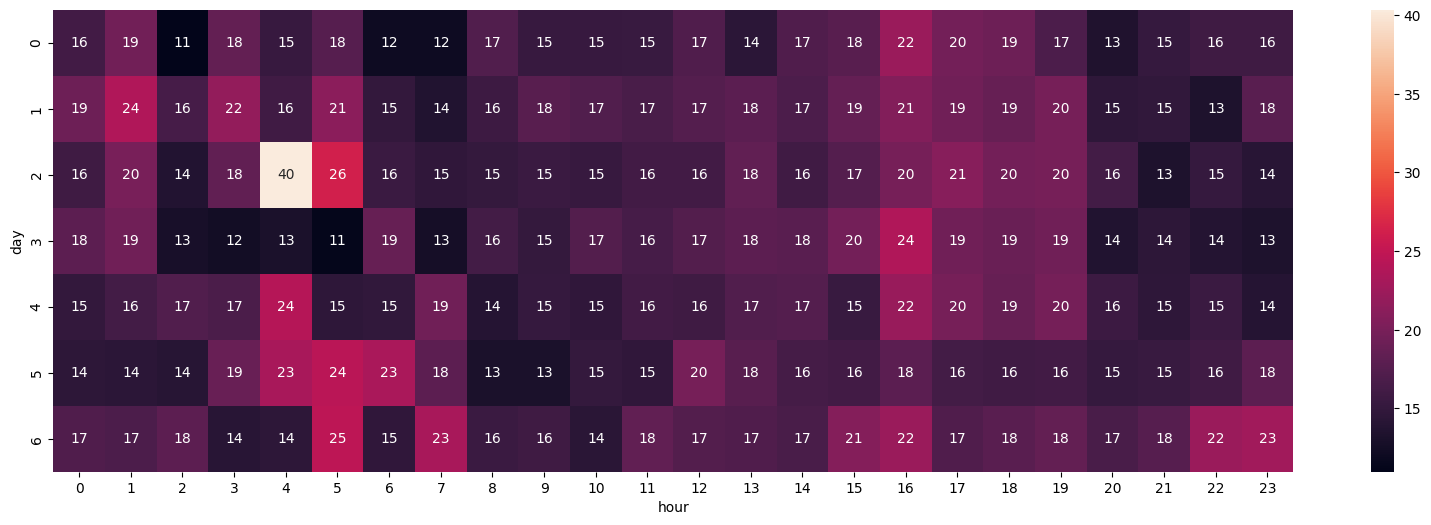

In [105]:
#plot the comparison of average fare per mile between days of week and hours of the day
plt.figure(figsize=(20,6))
sns.heatmap(pvt,annot=True)
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [106]:
# Compare fare per mile for different vendors
pvt=pd.pivot_table(data=df_filtered,values='fare_per_mile',index='VendorID',columns='hour') # mean is the default agg_func
#Display average fare per mile for all combinations of vendor and hours of a day
pvt


hour             0          1          2          3          4          5   \
VendorID                                                                     
1         11.404987  11.751060  11.884053  11.139254  11.448764  10.818182   
2         17.556204  18.420399  16.816066  18.093291  22.586931  23.240152   

hour             6          7          8          9   ...         14  \
VendorID                                              ...              
1         10.343541  11.423666  12.675467  13.148880  ...  13.453129   
2         18.354623  16.682827  16.504580  16.413539  ...  18.168934   

hour             15         16         17         18         19         20  \
VendorID                                                                     
1         13.765187  15.211151  15.131574  15.094764  14.160138  12.717288   
2         19.465301  23.494991  20.442127  19.711466  20.235973  15.732000   

hour             21         22         23  
VendorID                                   
1         12.266773  11.790785  11.422041  
2         15.655807  16.686622  17.463018  

[2 rows x 24 columns]

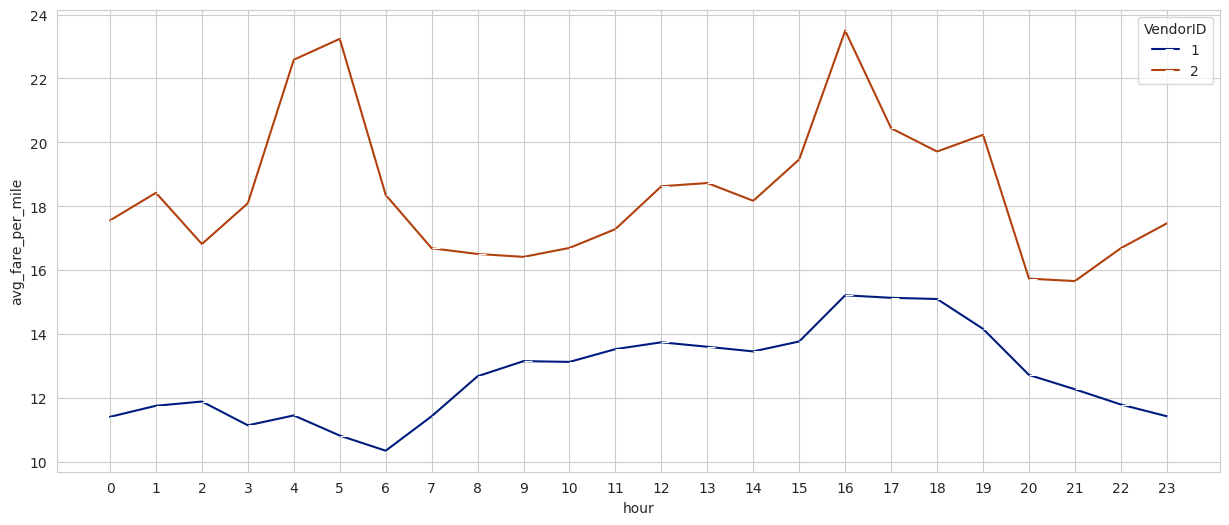

In [107]:
#Because from the above pivot, there are not many vendors, we could use a lineplot to comprare the two vendors across different hours of the day
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.lineplot(data=df_filtered,x='hour',y='fare_per_mile',hue='VendorID',marker=True,palette='dark',errorbar=None) # mean is the default estimator
plt.xticks(range(0,24))
plt.ylabel("avg_fare_per_mile")
plt.show()
#From the below plot it is clean that VendorID=2 has higher fare than VendorID=1

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [108]:
# Defining distance tiers
def get_distiance_tier(x):
    if 0 <= x <= 2:
        return 'Upto 2 miles'
    elif 2 < x <= 5:
        return '2 to 5 miles'
    else:
        return 'More than 5 miles'



In [109]:
df_filtered['tiers']=df_filtered.trip_distance.apply(lambda x: get_distiance_tier(x))
pvt=pd.pivot_table(data=df_filtered,values='fare_per_mile',index='VendorID',columns='tiers') # mean is the default agg_func
#Display average fare per mile for all combinations of vendor and tiers (obtained above)
pvt

tiers     2 to 5 miles  More than 5 miles  Upto 2 miles
VendorID                                               
1             9.185283           5.992588     17.203169
2             9.488182           6.171294     26.821922

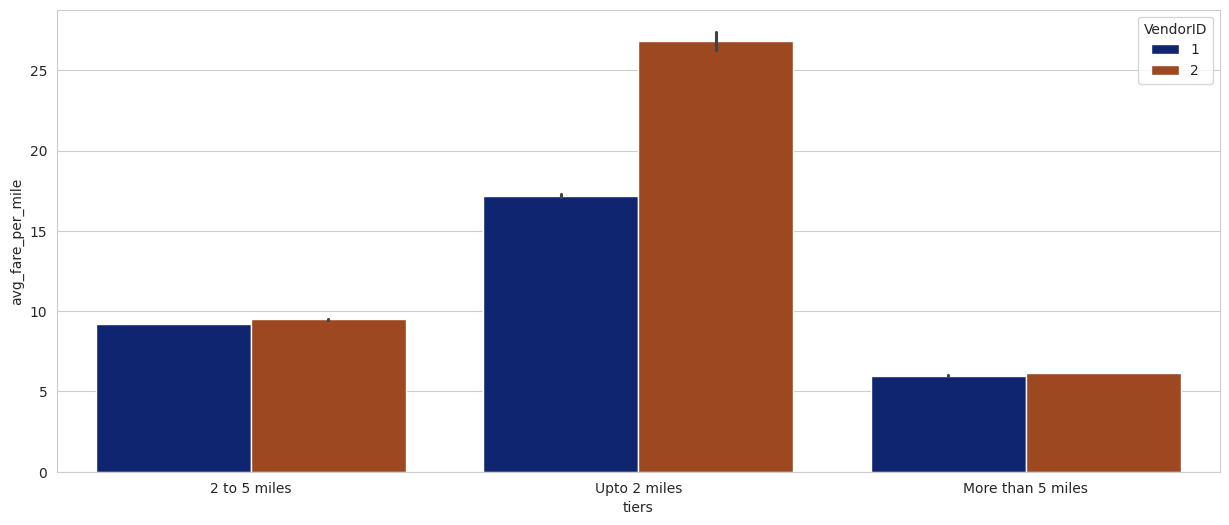

In [110]:
#plot the average fare per mile between distance tiers and vendor
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.barplot(data=df_filtered,x='tiers',y='fare_per_mile',hue='VendorID',palette='dark') # mean is the default estimator
plt.ylabel("avg_fare_per_mile")
plt.show()
#Below plot gives us an idea that VendorID=2 is expensive below 2 miles trip distance and higher than 2 miles it is competitive with VendorID=1

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

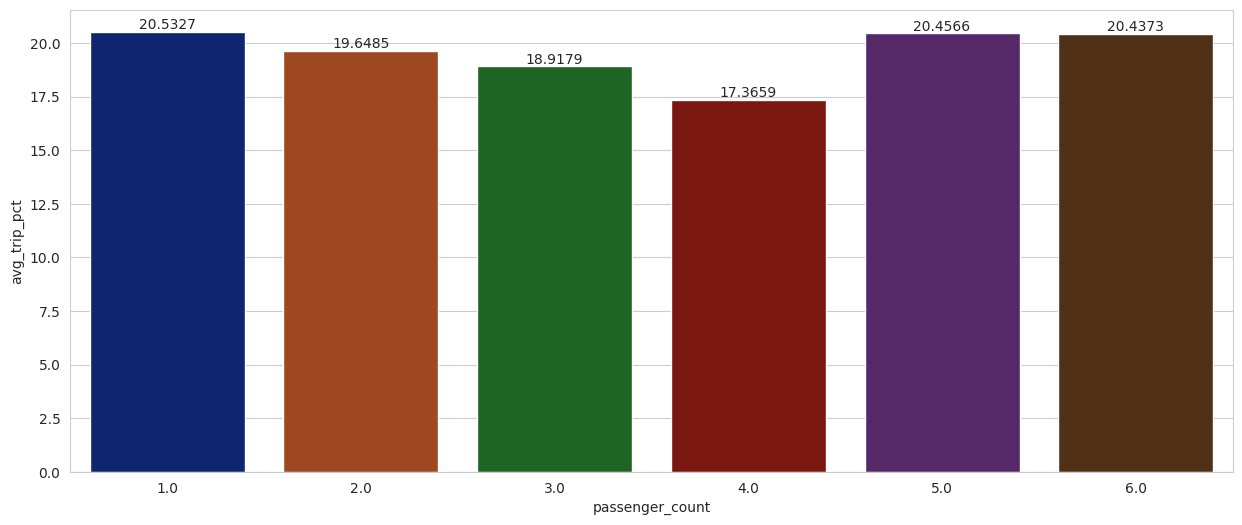

In [111]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# set tip percentage as an additional column to be used for further analysis
df_filtered['tip_pct']=(df_filtered.tip_amount/df_filtered.fare_amount) * 100

#plot average tip percentage vs passenger count in barplot
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
ax=sns.barplot(data=df_filtered,x='passenger_count',y='tip_pct',palette='dark',errorbar=None) # mean is the default estimator
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("avg_trip_pct")
plt.show()

#tip percentage is more or less around 20% for passenger counts


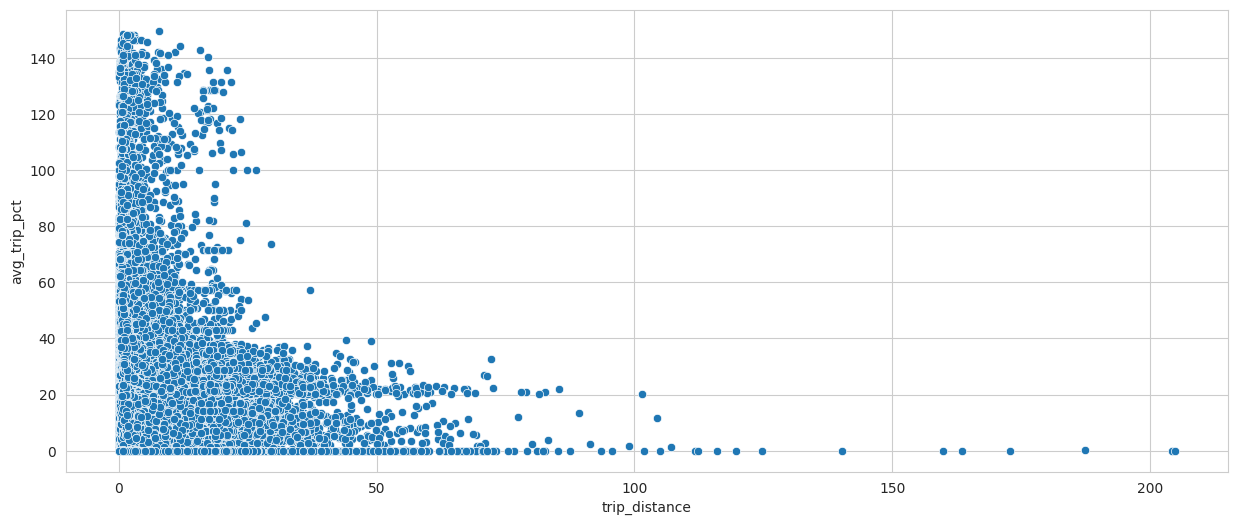

In [112]:
#plot tip percentage vs distances as scatter plot
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.scatterplot(data=df_filtered,x='trip_distance',y='tip_pct',palette='dark') # mean is the default estimator
plt.ylabel("avg_trip_pct")
plt.show()

#tip percentage is remains mostly between 0% to 20% as evident from the scatter plot below

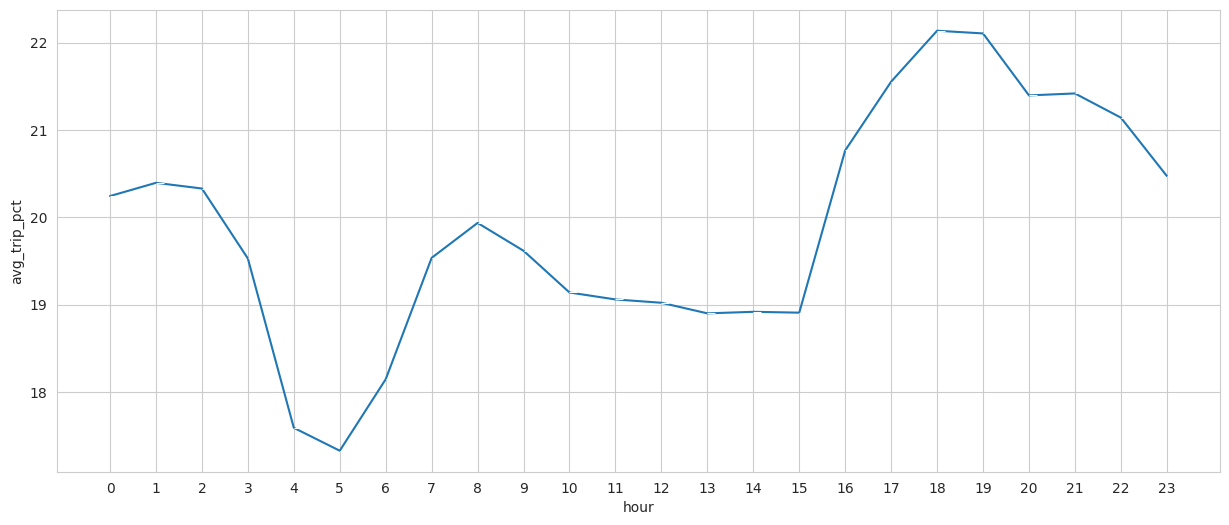

In [113]:
#plot tip percentage vs pickup hours as line plot
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.lineplot(data=df_filtered,x='hour',y='tip_pct',palette='dark',marker=True,errorbar=None) # mean is the default estimator
plt.xticks(range(0,24))
plt.ylabel("avg_trip_pct")
plt.show()

# average tip percentage is low between 4:00 am to 6:00 am. It is high around 06:00 PM

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [114]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

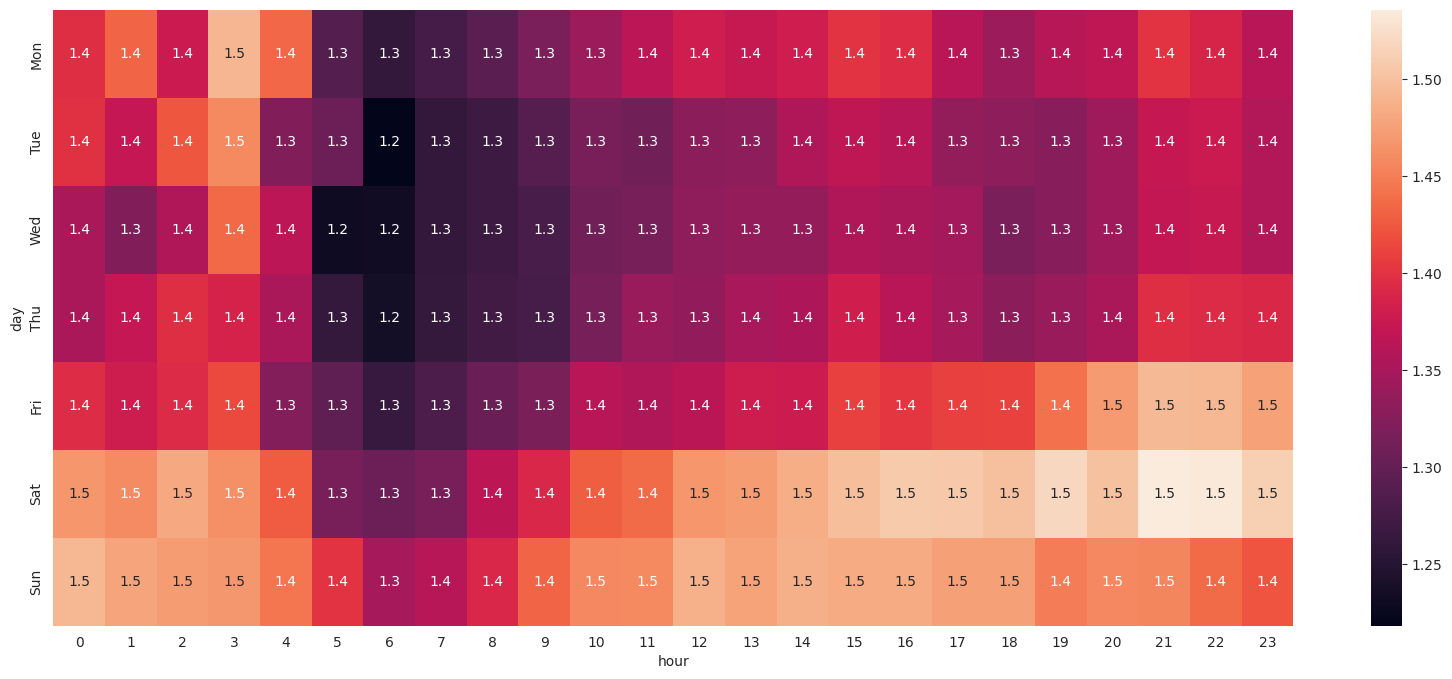

In [115]:
# See how passenger count varies across hours and days
plt.figure(figsize=(20,8))
pvt=pd.pivot_table(data=df_filtered,values='passenger_count',columns='hour',index='day')
sns.heatmap(pvt,yticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],annot=True)
plt.show()

# passenger count is higher usually during weekends especially late hours

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

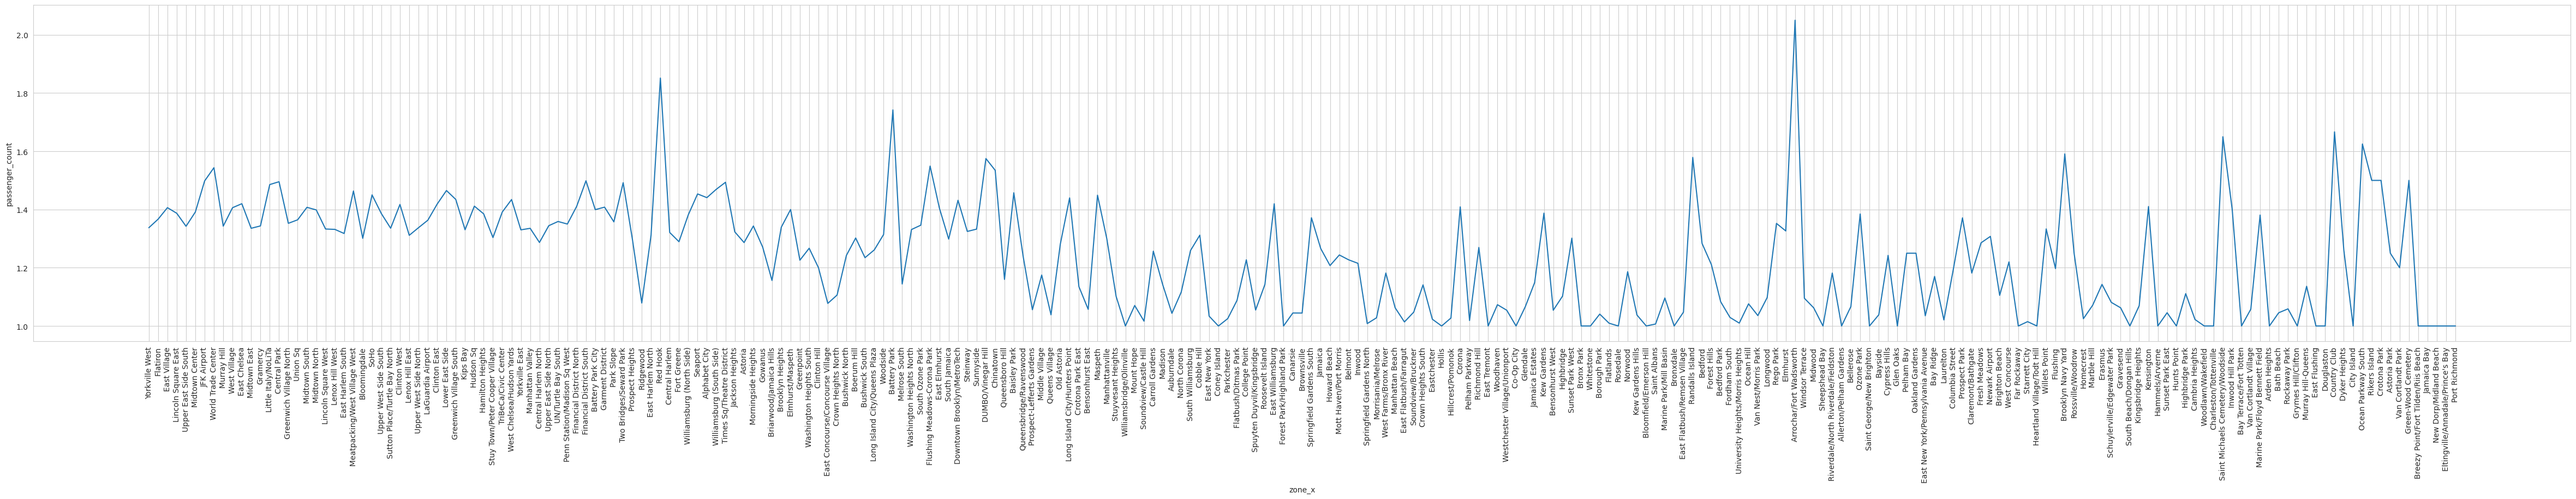

In [116]:
# How does passenger count vary across zones
plt.figure(figsize=(60,8))
sns.set_style('whitegrid')
sns.lineplot(data=df_filtered_zone,x='zone_x',y='passenger_count',errorbar=None,palette='dark')
plt.xticks(rotation=90)
plt.show()


In [117]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zone_count= pd.merge(left=zone_count,
                     right= df_filtered.groupby(by='PULocationID')[['passenger_count']].mean().reset_index(),
                     left_on='LocationID',
                     right_on='PULocationID'
                     )
zone_count.drop(columns='PULocationID',axis=1,inplace=True)

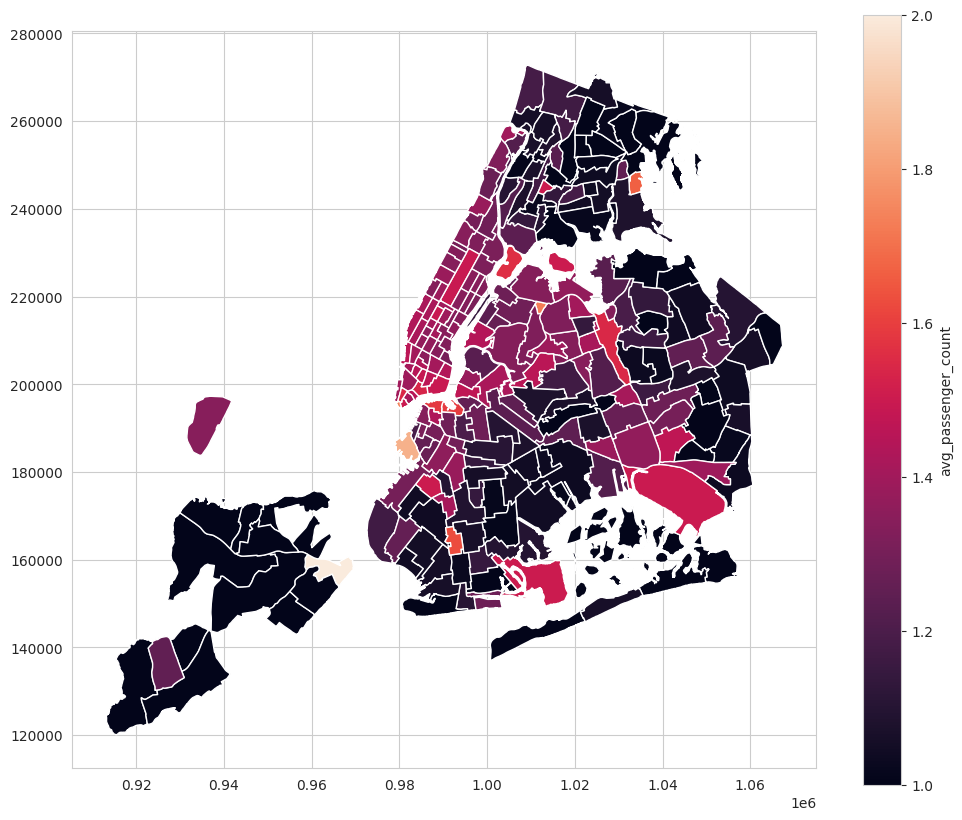

In [118]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
zone_count.plot(column = 'passenger_count',
                ax = ax,
                legend = True,
                legend_kwds = {'label': "avg_passenger_count", 'orientation': "vertical"})
plt.show()

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [119]:
# How often is each surcharge applied?
# Idea is to determine the for each of congestion_surcharge, improvement_surcharge and extra, how often they are changed
# So we proceed with one at a time against the pickup zone and hour

#Below is a custom function used as aggregate in subsequent pivot table.
# Here we only add 1 if the respective amount is greater than 0.
def surcharge_applied_agg(x):
    total=0
    for i in x:
        total=total + (1 if i > 0 else 0)
    return total


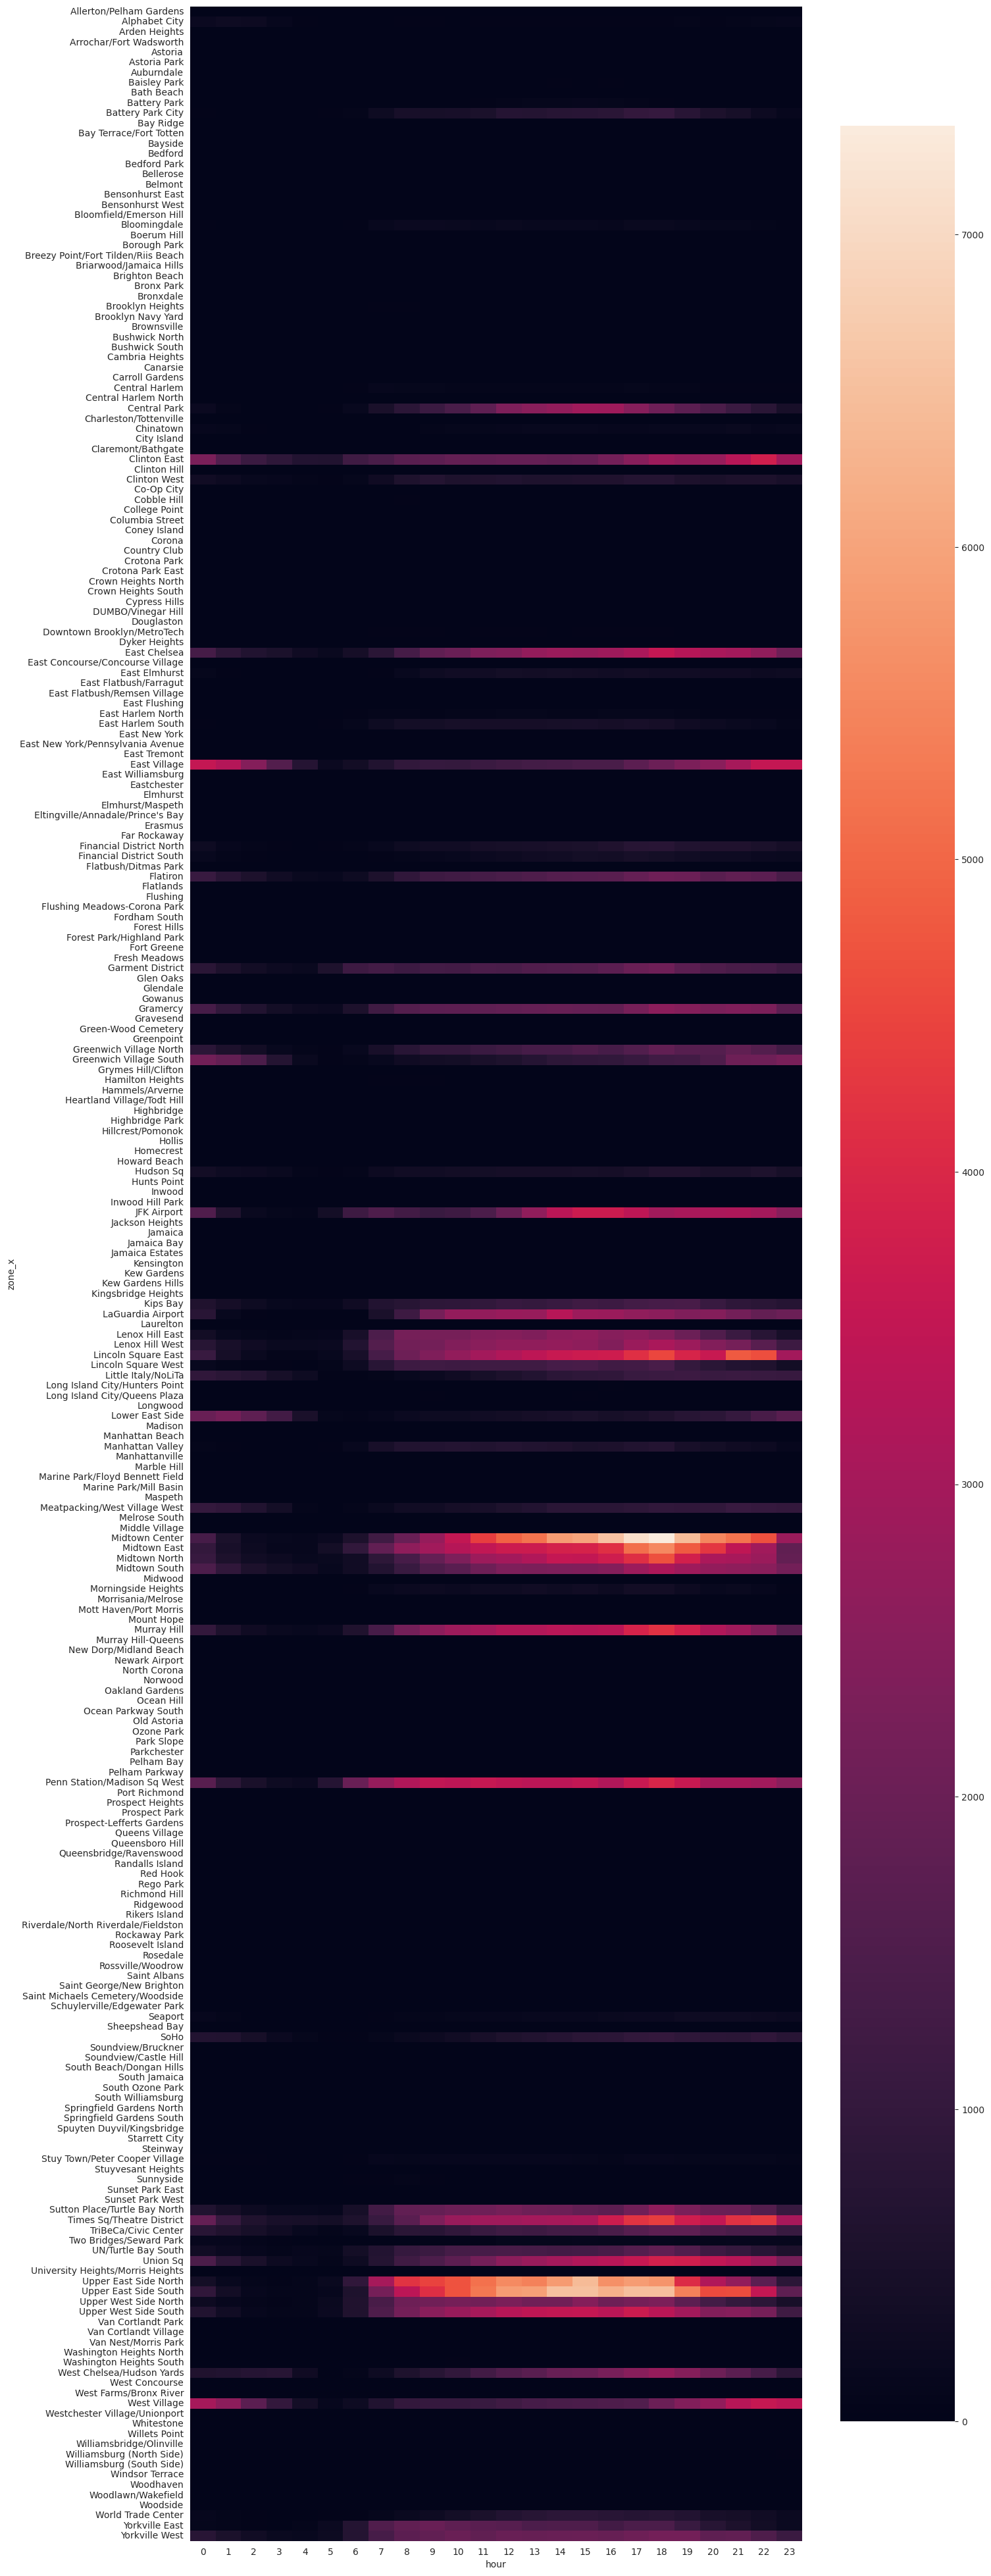

In [120]:
# Plot a heap map between pickup zone and hours with congestion_surcharge as value, to see where and when usually congestion_surcharge is applied
pvt=pd.pivot_table(data=df_filtered_zone,values='congestion_surcharge',columns='hour',index='zone_x',aggfunc=surcharge_applied_agg,fill_value=0.0)
plt.figure(figsize=(15,50))
sns.set_style('whitegrid')
sns.heatmap(pvt)
plt.show()
#From the below heatmap, we can conclude that congestion_surcharge is applied more often between 2:00 PM to 7:00 PM at ones : Midtown Centre, Midtown East, Upper East Side North, Upper East Side South

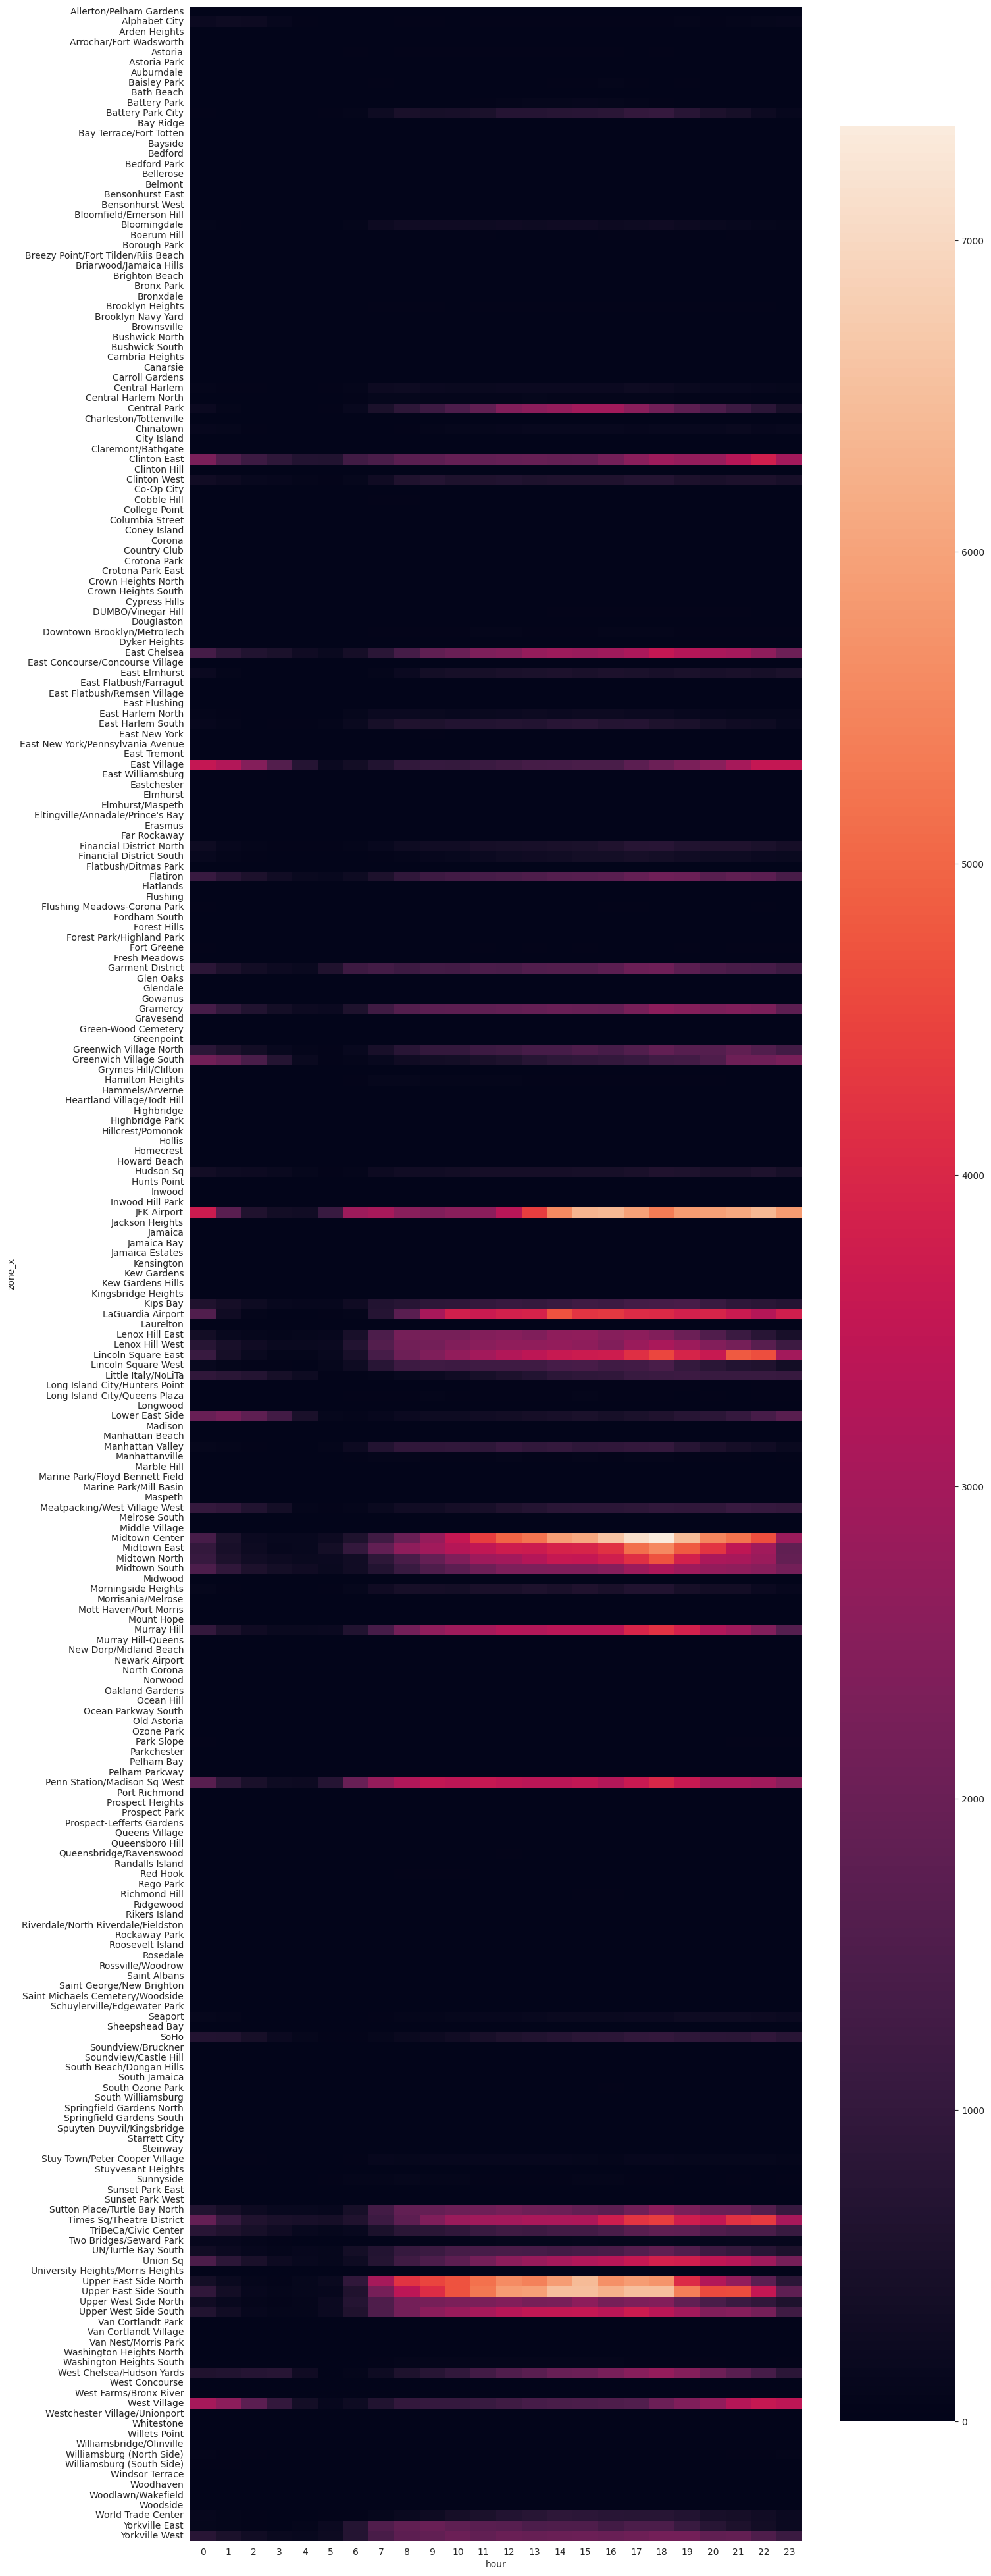

In [121]:
# Plot a heap map between pickup zone and hours with improvement_surcharge as value, to see where and when usually congestion_surcharge is applied
pvt=pd.pivot_table(data=df_filtered_zone,values='improvement_surcharge',columns='hour',index='zone_x',aggfunc=surcharge_applied_agg,fill_value=0.0)
plt.figure(figsize=(15,50))
sns.set_style('whitegrid')
sns.heatmap(pvt)
plt.show()
#From the below heatmap, we can conclude that improvement_surcharge is applied more often between 2:00 PM to 7:00 PM at ones : Midtown East, Upper East Side North, Upper East Side South
# For zone JFK Airport, the improvement_surcharge is applied from 2:00 PM till midnight

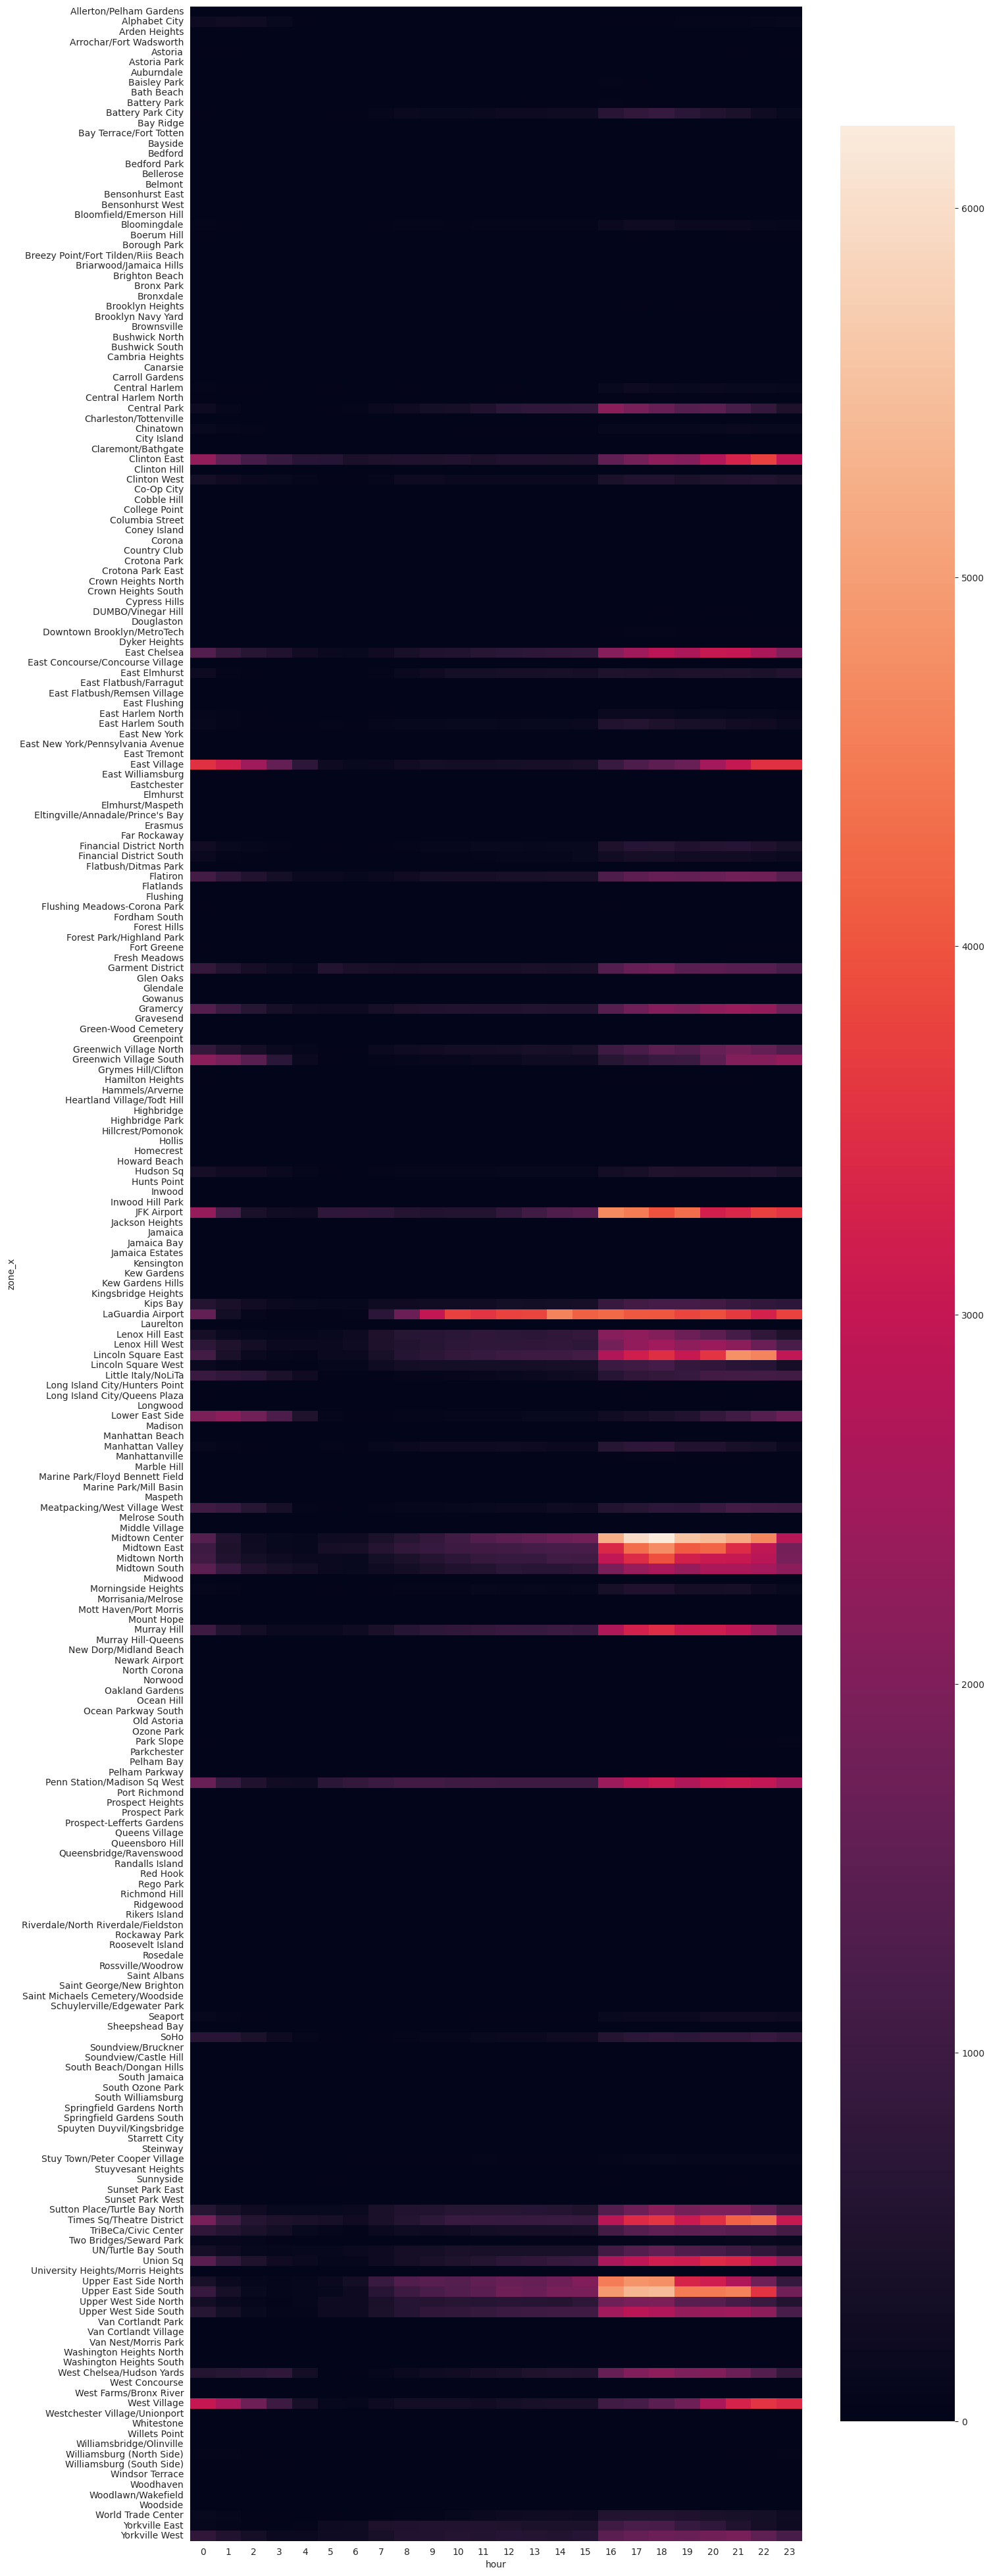

In [122]:
# Plot a heap map between pickup zone and hours with extra as value, to see where and when usually congestion_surcharge is applied
pvt=pd.pivot_table(data=df_filtered_zone,values='extra',columns='hour',index='zone_x',aggfunc=surcharge_applied_agg,fill_value=0.0)
plt.figure(figsize=(15,50))
sns.set_style('whitegrid')
sns.heatmap(pvt)
plt.show()
#From the below heatmap, we can conclude that extra is applied more often after  4:00 PM at zones: Midtown East, Upper East Side North, Upper East Side South, LaGuardia Aiport, JFK Airport

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

1. As per section 3.2.1, the slowest routes with hours are listed down.
It is quite obvious to review them because the trip distance is too small to have taken so large time to cover the trip.

2. From section 3.2.2, 3.2.3 & 3.2.4, we can infer that -
a. busiest times are between 17:00 hrs - 19:00 hrs on Wednesdays and Thursdays.
b. Weekends on are not as busy. It is worth noticing that weekends during early hours (00:00 to 02:00) it is busier that other days for the same time. Busy and quiet hours determination will help us allocate resources accordingly thereby reducing idle time.

3. In section 3.2.5 and 3.2.6, we have identified the highest pickup/drop ratio and also lowest pickup/dropoff ratio.
From this result we can make sure that these zone with higher pickup ratio needs to be allocated with more cars than the ones with low ratio.

4. It could be an good idea to route more cabs towards the zones with high pickup counts. However to send cabs without any customer to high pickup zones, there could be a busy zone fees to cover the cost


**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

    1. As per section 3.1.2, the following is deduced:
        a. As mentioned before, hours when the pickup is higher are around 18:00 hrs
        b. Also among weekdays, Wed and Thur have more bookings that other days. However on weekends the trend is high on booking between 00:00 to 02:00
        c. Month wise, May and October have the highest pickup counts
    so for those hour, days and months, it could be planned to have right allocation of resources.

2. As per section 3.1.13, it is identified that some of the busiest zones with high pickup counts.
Cabs could be directed to those zones as per the required demand so that the cabs are not idle in zones which are with lower pickup count.

3. As per section 3.2.14, higher passenger counts are mostly seen during late hours and early hours on weekends.
So during these times, deployment of bigger cars could be a good idea.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

1. From section 3.2.8, it is evident that day time ( 5 AM to 11 PM) bookings are 7 times higher than night time (11 PM to 5 AM).
So it would be wise to allocate cab also in the same ratio between day time and night time to reduce idle time and reduce cost

2. From section 3.2.9, we have seen that average fare/mile/person falls with passenger count.
So it is better to promote cab sharing so that cost to the customer is less and also number of cabs to be deployed also reduces thereby reducing cost.

3. In section 3.2.11, average fare/mile/person is different between two vendors. One vendor being higher than other.
This could be settled as the route and distance is the same for both, so cost also should be the comparable between the two.